<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/Colab_Notebooks/CIFAR_RESNNET_SHAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install adversarial-robustness-toolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 31.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.20.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.1.3 which is incompatible.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import load_model

if tf.__version__[0] == "2":
    tf.compat.v1.disable_eager_execution()

from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.defences.detector.evasion import BinaryInputDetector

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('cifar10')



In [ ]:
x_train.shape

(50000, 32, 32, 3)

In [ ]:
# import tensorflow as tf

# # Load CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()




In [ ]:
from tensorflow.keras.models import load_model

# Load pre-trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/CIFAR/cifar_resnet.h5')
classifier_model = model
# classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False,
                             preprocessing=(0.5, 1))

In [ ]:
x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test, axis=1))

print("Original test data ( 1000 images):")
print("Correctly classified: {}".format(nb_correct_pred))


Original test data ( 1000 images):
Correctly classified: 9241


In [ ]:
import numpy as np

# Assuming x_test is your test data and y_test are the true labels
# And classifier.predict(x_test) is how you obtain predictions

x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
true_labels = np.argmax(y_test, axis=1)

# Identify correctly classified examples
correct_indices = np.where(x_test_pred == true_labels)[0]
correct_examples = x_test[correct_indices]
correct_labels = y_test[correct_indices]

# Count correctly and incorrectly classified examples
nb_correct_pred = len(correct_indices)
nb_incorrect_pred = len(x_test) - nb_correct_pred

print("Original test data (1000 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(nb_incorrect_pred))

# Optionally, save the correctly classified examples and labels
# np.save('correct_examples.npy', correct_examples)
# np.save('correct_labels.npy', correct_labels)


Original test data (1000 images):
Correctly classified: 9241
Incorrectly classified: 759


In [ ]:
import numpy as np

# Assuming you have loaded CIFAR-10 data and labels
# x_adv_loaded, correct_examples, correct_labels are available

# Define the number of examples to select per class
examples_per_class = 10  # 100 examples (50 correct, 50 adversarial) per class for a total of 1000 examples

# Initialize empty lists to store selected examples and labels
selected_correct_examples = []
selected_labels = []  # New list to store corresponding class labels

# Initialize dictionaries to keep track of selected examples per class
selected_examples_per_class_correct = {}


# Shuffle the indices to randomly select examples
shuffled_indices = np.arange(len(correct_examples))
np.random.shuffle(shuffled_indices)

# Iterate through shuffled indices
for idx in shuffled_indices:
    correct_example = correct_examples[idx]
    correct_label = np.argmax(correct_labels[idx])  # Convert one-hot encoding to integer label


    # Check if the class (as an integer) is already present in selected_examples_per_class
    if correct_label not in selected_examples_per_class_correct:
        selected_examples_per_class_correct[correct_label] = 0


    # Check if we have selected enough examples for this class
    if (
        selected_examples_per_class_correct[correct_label] < examples_per_class // 2
    ):
        selected_examples_per_class_correct[correct_label] += 1
        selected_labels.append(correct_label)  # Add the corresponding label
        selected_correct_examples.append(correct_example)

    # Check if we have selected enough examples overall
    if len(selected_labels) == examples_per_class * len(selected_examples_per_class_correct):
        break

# Convert selected examples and labels to NumPy arrays
selected_correct_examples = np.array(selected_correct_examples)
selected_labels = np.array(selected_labels)


In [ ]:
x_test_pred = np.argmax(classifier.predict(selected_correct_examples), axis=1)
nb_correct_pred = np.sum(x_test_pred == selected_labels)

print("Original test data ( 50 images):")
print("Correctly classified: {}".format(nb_correct_pred))
def calculate_accuracy(predictions, ground_truth):
    correct = np.sum(predictions == ground_truth)
    total = len(ground_truth)
    accuracy = correct / total
    return accuracy*100

accuracy_original = calculate_accuracy(x_test_pred, selected_labels)

Original test data ( 50 images):
Correctly classified: 50


In [ ]:
accuracy_original

100.0

# **Generating Test Cases**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import pickle
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.estimators.classification import TensorFlowV2Classifier  # Adjust based on your model framework


# List of attacks to be evaluated
attacks = [ProjectedGradientDescent]

# Define the range of eps values
eps_range = [0.03]
results = []
def perform_and_save_attack(attack_class, eps, x_examples, y_true, classifier, attack_name):
    """
    Perform an attack, return the accuracy, adversarial examples, and true labels, and save the adversarial examples with labels.
    """
    attack = attack_class(classifier, eps=eps)
    x_adv = attack.generate(x=x_examples)
    y_pred_adv = np.argmax(classifier.predict(x_adv), axis=1)

    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_flat = np.argmax(y_true, axis=1)
    else:
        y_true_flat = y_true

    accuracy_adv = accuracy_score(y_true_flat, y_pred_adv)

    # Save the adversarial examples and their true labels
    save_path = f'/content/drive/MyDrive/ColabNotebooks/CIFAR/{attack_name}_eps_{eps}.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump({'x_adv': x_adv, 'y_true': y_true}, f)

    return accuracy_adv, x_adv, y_true

# Dictionary to store adversarial examples and labels
adversarial_data = {}

# Evaluate each attack at each epsilon value and save the adversarial examples
for attack in attacks:
    for eps in eps_range:
        accuracy_adv, x_adv, y_true_adv = perform_and_save_attack(attack, eps, selected_correct_examples, selected_labels, classifier, attack.__name__)
        results.append({
            'Attack': attack.__name__,
            'Epsilon': eps,
            'Accuracy': accuracy_adv
        })
        # Storing adversarial examples and labels in the dictionary
        adversarial_data[f'{attack.__name__}_eps_{eps}'] = {'x_adv': x_adv, 'y_true': y_true_adv}

# Now, `adversarial_data` contains all the adversarial examples and labels for further use


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import pickle

def load_adversarial_data(file_path):
    """
    Load adversarial examples and labels from a pickle file.

    Parameters:
    - file_path: The path to the pickle file containing the saved adversarial examples and labels.

    Returns:
    - A dictionary with keys 'x_adv' and 'y_true' corresponding to the adversarial examples and their true labels.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Example usage
file_path = '/content/drive/MyDrive/ColabNotebooks/CIFAR/ProjectedGradientDescent_eps_0.03.pkl'
loaded_data = load_adversarial_data(file_path)

# Accessing the adversarial examples and labels
x_adv_loaded = loaded_data['x_adv']
y_true_loaded = loaded_data['y_true']

# Now, `x_adv_loaded` and `y_true_loaded` can be used for further analysis or evaluation


In [ ]:
x_test_pred = np.argmax(classifier.predict(x_adv_loaded), axis=1)
nb_correct_pred = np.sum(x_test_pred == selected_labels)

print("Original test data ( 50 images):")
print("Correctly classified: {}".format(nb_correct_pred))
def calculate_accuracy(predictions, ground_truth):
    correct = np.sum(predictions == ground_truth)
    total = len(ground_truth)
    accuracy = correct / total
    return accuracy

accuracy_adv = calculate_accuracy(x_test_pred, selected_labels)

Original test data ( 50 images):
Correctly classified: 0


In [ ]:
accuracy_adv

0.0

In [ ]:
x_test_pred = np.argmax(classifier.predict(x_adv_loaded), axis=1)
nb_correct_pred = np.sum(x_test_pred == y_true_loaded)

print("Original test data ( 50 images):")
print("Correctly classified: {}".format(nb_correct_pred))

Original test data ( 50 images):
Correctly classified: 1


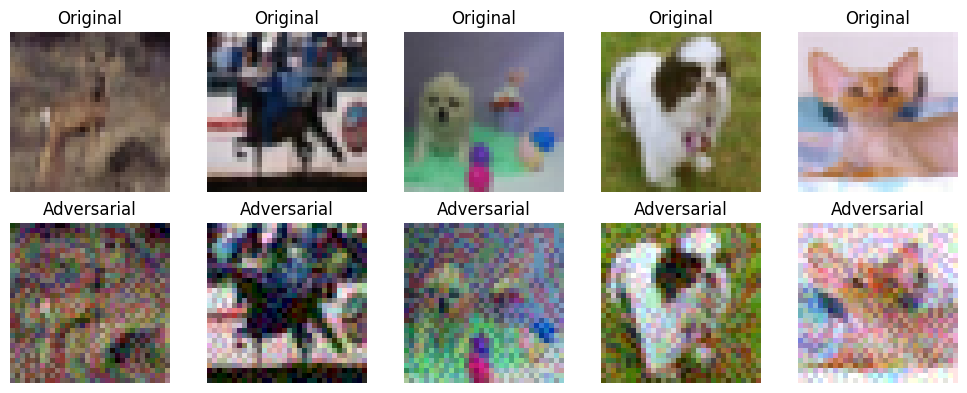

In [ ]:
import matplotlib.pyplot as plt

def plot_comparison(original, adversarial, num_examples=5):
    """
    Plot a comparison between original and adversarial examples.

    Parameters:
    - original: NumPy array of original examples.
    - adversarial: NumPy array of adversarial examples, corresponding to the original examples.
    - num_examples: Number of examples to plot.
    """
    plt.figure(figsize=(2*num_examples, 4))
    for i in range(num_examples):
        # Plot original example
        plt.subplot(2, num_examples, i+1)
        plt.imshow(original[i].squeeze(), cmap='gray' if original[i].shape[-1] == 1 else None)
        plt.title("Original")
        plt.axis('off')

        # Plot adversarial example
        plt.subplot(2, num_examples, num_examples+i+1)
        plt.imshow(adversarial[i].squeeze(), cmap='gray' if adversarial[i].shape[-1] == 1 else None)
        plt.title("Adversarial")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Assuming `x_adv_loaded` is your loaded adversarial examples and `correct_examples` are your original examples
# Example usage:
plot_comparison(selected_correct_examples, x_adv_loaded, num_examples=5)


# **Data Perturbations**

In [ ]:
import numpy as np
import cv2

def add_noise(image):
    noise = np.random.normal(0, 0.05, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return rotated_image

def adjust_brightness(image, factor):
    bright_image = np.clip(image * factor, 0, 255)
    return bright_image



In [ ]:
def apply_perturbation_to_all_images(images, perturbation_func, **kwargs):
    perturbed_images = np.array([perturbation_func(image, **kwargs) if perturbation_func != rotate_image else perturbation_func(image, **kwargs).reshape(image.shape) for image in images])
    return perturbed_images

# Assuming `correct_examples` is your dataset of correct images
# Apply noise to all correct examples
all_correct_noisy = apply_perturbation_to_all_images(selected_correct_examples, add_noise)

# Apply rotation to all correct examples (e.g., 45 degrees)
all_correct_rotated = apply_perturbation_to_all_images(selected_correct_examples, rotate_image, angle=45)

# Apply brightness adjustment to all correct examples (e.g., increase brightness by 50%)
all_correct_bright = apply_perturbation_to_all_images(selected_correct_examples, adjust_brightness, factor=1.5)


In [ ]:
import matplotlib.pyplot as plt

def visualize_images(image_list, title_list, figsize=(20, 10)):
    """
    Visualizes a list of images with corresponding titles.

    Parameters:
    - image_list: List of images to be displayed.
    - title_list: List of titles for each image.
    - figsize: Tuple indicating figure size.
    """
    n = len(image_list)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(image_list[i])
        plt.title(title_list[i])
        plt.axis('off')
    plt.show()


# **Visualizing the Test Cases**

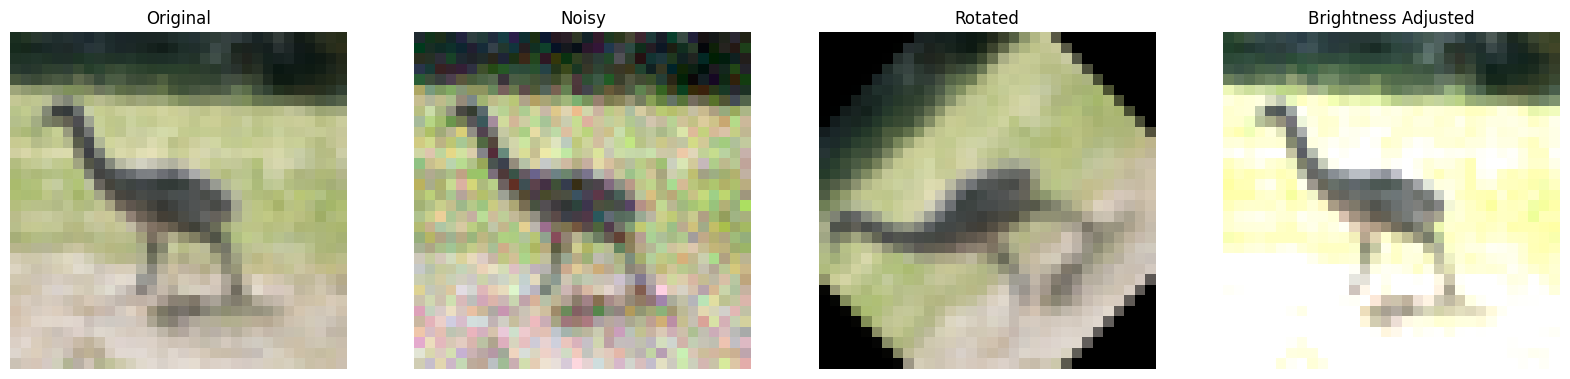

In [ ]:
# Assuming you have an index for the image you want to visualize
index = 14  # Change as needed

visualize_images(
    [selected_correct_examples[index], all_correct_noisy[index], all_correct_rotated[index], all_correct_bright[index]],
    ["Original", "Noisy", "Rotated", "Brightness Adjusted"]
)


# **Evaluating the Model**

In [ ]:
from sklearn.metrics import accuracy_score

import numpy as np
from tensorflow.image import resize
from tensorflow.keras.applications.vgg16 import preprocess_input



import numpy as np

def model_predict(model, images):
    """
    Predicts labels for a set of images using a given model.

    Parameters:
    - model: The trained Keras model for prediction.
    - images: Preprocessed images suitable for the model.

    Returns:
    - An array of predicted labels.
    """

    predicted_labels = np.argmax(model.predict(images), axis=1)

    return predicted_labels


# # Preprocess all sets of perturbed images
# processed_noisy = preprocess_images(all_correct_noisy)
# processed_rotated = preprocess_images(all_correct_rotated)
# processed_bright = preprocess_images(all_correct_bright)

# Predict labels for each set of perturbed images
predictions_noisy = model_predict(classifier, all_correct_noisy)
predictions_rotated = model_predict(classifier, all_correct_rotated)
predictions_bright = model_predict(classifier, all_correct_bright)



In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Check the format and shape of true labels
print("Shape of correct_labels:", selected_labels.shape)
print("Unique class labels in correct_labels:", np.unique(selected_labels))

# Check the format and shape of predicted labels
print("Shape of predictions_noisy:", predictions_noisy.shape)
print("Unique class labels in predictions_noisy:", np.unique(predictions_noisy))


Shape of correct_labels: (50,)
Unique class labels in correct_labels: [0 1 2 3 4 5 6 7 8 9]
Shape of predictions_noisy: (50,)
Unique class labels in predictions_noisy: [0 1 2 3 4 5 6 7 8 9]


In [ ]:

# Calculate accuracy for each set of perturbed images
accuracy_noisy = accuracy_score(selected_labels, predictions_noisy)
accuracy_rotated = accuracy_score(selected_labels, predictions_rotated)
accuracy_bright = accuracy_score(selected_labels, predictions_bright)

# Print accuracies
print(f"Accuracy (Noisy): {accuracy_noisy:.4f}")
print(f"Accuracy (Rotated): {accuracy_rotated:.4f}")
print(f"Accuracy (Brightness Adjusted): {accuracy_bright:.4f}")

Accuracy (Noisy): 0.8200
Accuracy (Rotated): 0.3400
Accuracy (Brightness Adjusted): 0.9800


# **ImageDataGenerator**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# Create an instance of ImageDataGenerator with desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation within the range (-20, 20) degrees
    width_shift_range=0.1,  # Random horizontal shift within the range (-10%, 10%)
    height_shift_range=0.1,  # Random vertical shift within the range (-10%, 10%)
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    fill_mode='nearest'  # How to fill newly created pixels
)

# Assuming `correct_examples` is your dataset of correct images
# Convert the dataset to a generator
datagen.fit(selected_correct_examples)
selected_labels = to_categorical(selected_labels, 10)
# Evaluate the model on the augmented dataset
accuracy = model.evaluate(datagen.flow(selected_correct_examples, selected_labels), verbose=0)

print(f"Accuracy on augmented dataset: {accuracy[1]*100:.2f}%")


Accuracy on augmented dataset: 82.00%


# **Original image change_brightness 10,20,30 percent**

In [ ]:
import numpy as np

# Define a function to calculate accuracy
def calculate_accuracy(predictions, ground_truth):
    correct = np.sum(predictions == ground_truth)
    total = len(ground_truth)
    accuracy = correct / total
    return accuracy

# Define a function to randomly change brightness of pixels
def adjust_brightness_random_pixels(image, percentage_change):
    """
    Randomly changes the brightness of a percentage of pixels in the image.

    Parameters:
    - image: Input image as a NumPy array.
    - percentage_change: Percentage of pixels to change brightness.

    Returns:
    - Perturbed image.
    """
    perturbed_image = np.copy(image)
    height, width, channels = image.shape

    # Calculate the number of pixels to perturb
    num_pixels = int(percentage_change * height * width / 100)

    # Randomly select pixel positions to perturb
    pixel_positions = np.random.choice(height * width, num_pixels, replace=False)

    # Apply brightness change to selected pixels
    for pixel_position in pixel_positions:
        row = pixel_position // width
        col = pixel_position % width
        # Modify the brightness of the pixel here (e.g., increase or decrease intensity)
        perturbed_image[row, col] = np.clip(perturbed_image[row, col] * 0.5, 0, 255)  # Example: Decrease brightness

    return perturbed_image

# Example usage:
percentage_changes = [10, 20, 30]

# Initialize a list to store accuracies for each percentage change
accuracies = []

# Assuming `correct_examples` is your dataset of correct images
for percentage in percentage_changes:
    perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in selected_correct_examples]

    # Assuming you have a model that can make predictions, replace the following line with your model's predictions
    model_predictions = np.argmax(classifier.predict(perturbed_images), axis=1)  # Model predictions
    # Convert one-hot encoded ground truth labels to class indices
    ground_truth_indices = [np.argmax(label) for label in selected_labels]
    # Assuming `selected_labels` is a list of ground truth labels corresponding to `selected_correct_examples`
    accuracy = calculate_accuracy(model_predictions, ground_truth_indices)

    accuracies.append(accuracy)

# Print accuracies for each percentage change
for i, percentage in enumerate(percentage_changes):
    print(f'Accuracy for {percentage}% brightness change: {accuracies[i] * 100:.2f}%')


Accuracy for 10% brightness change: 60.00%
Accuracy for 20% brightness change: 40.00%
Accuracy for 30% brightness change: 14.00%


In [ ]:
# Example usage:
percentage_changes = [0, 10, 20, 30]

# Assuming `correct_examples` is your dataset of correct images
for percentage in percentage_changes:
    perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in selected_correct_examples]

    # Assuming you have a model that can make predictions, replace the following line with your model's predictions
    model_predictions = np.argmax(classifier.predict(perturbed_images), axis=1)  # Model predictions

    # Convert one-hot encoded ground truth labels to class indices
    ground_truth_indices = [np.argmax(label) for label in selected_labels]

    accuracy = calculate_accuracy(model_predictions, ground_truth_indices)

    print(f'Accuracy for {percentage}% brightness change: {accuracy * 100:.2f}%')

    # Debugging prints
    for i, (pred, label_idx) in enumerate(zip(model_predictions, ground_truth_indices)):
        print(f"Prediction: {pred}, Ground Truth Label Index: {label_idx}")
        # You can also print images here if needed
        # plt.imshow(perturbed_images[i])
        # plt.show()


Accuracy for 0% brightness change: 100.00%
Prediction: 4, Ground Truth Label Index: 4
Prediction: 7, Ground Truth Label Index: 7
Prediction: 5, Ground Truth Label Index: 5
Prediction: 5, Ground Truth Label Index: 5
Prediction: 3, Ground Truth Label Index: 3
Prediction: 9, Ground Truth Label Index: 9
Prediction: 5, Ground Truth Label Index: 5
Prediction: 1, Ground Truth Label Index: 1
Prediction: 8, Ground Truth Label Index: 8
Prediction: 3, Ground Truth Label Index: 3
Prediction: 2, Ground Truth Label Index: 2
Prediction: 7, Ground Truth Label Index: 7
Prediction: 1, Ground Truth Label Index: 1
Prediction: 6, Ground Truth Label Index: 6
Prediction: 2, Ground Truth Label Index: 2
Prediction: 1, Ground Truth Label Index: 1
Prediction: 6, Ground Truth Label Index: 6
Prediction: 8, Ground Truth Label Index: 8
Prediction: 5, Ground Truth Label Index: 5
Prediction: 5, Ground Truth Label Index: 5
Prediction: 8, Ground Truth Label Index: 8
Prediction: 2, Ground Truth Label Index: 2
Prediction:

Accuracy for 0% brightness change: 60.00%


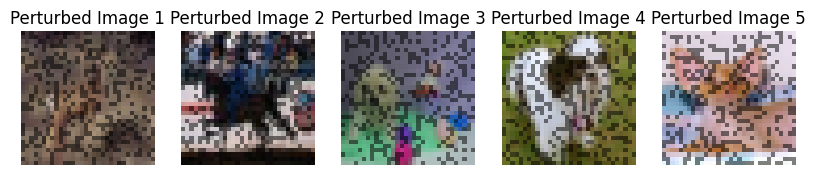

Accuracy for 10% brightness change: 40.00%


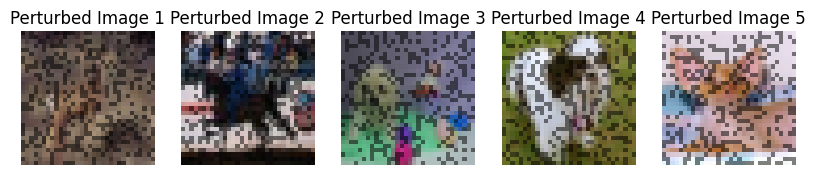

Accuracy for 20% brightness change: 14.00%


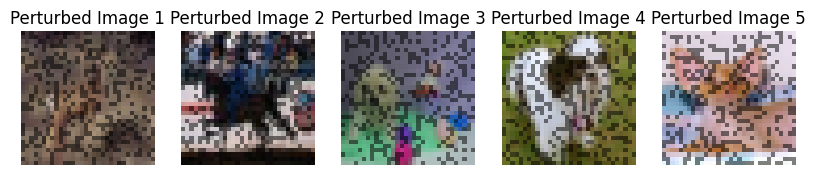

In [ ]:
for i in range(len(accuracies)):
    print(f'Accuracy for {percentage_changes[i]}% brightness change: {accuracies[i] * 100:.2f}%')

    # Display the perturbed images
    plt.figure(figsize=(10, 5))
    for j in range(5):  # Display the first 5 images
        plt.subplot(1, 5, j + 1)
        plt.imshow(perturbed_images[j])
        plt.title(f'Perturbed Image {j+1}')
        plt.axis('off')
    plt.show()

# **Adversarial Image Change 10,20,30**

In [ ]:
x_adv_loaded.shape

(9241, 32, 32, 3)

In [ ]:
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import accuracy_score

# Define the percentage of pixels to perturb
percentages = [10, 20, 30]

import numpy as np

def perturb_adversarial_with_original(adversarial_images, original_images, percentage):
    perturbed_images = []
    height, width = 32, 32  # Explicitly set for clarity, based on provided shapes

    for i in range(adversarial_images.shape[0]):
        adversarial_image = np.copy(adversarial_images[i])
        original_image = original_images[i]
        num_pixels = height * width  # 32 * 32 = 1024, as confirmed
        num_perturbed_pixels = int(percentage / 100 * num_pixels)

        # Debug: Print the number of pixels to be perturbed
        print(f"Perturbing {num_perturbed_pixels} pixels out of {num_pixels} ({percentage}%) for image {i+1}")

        # Generating unique pixel positions for perturbation
        pixel_positions = np.random.choice(num_pixels, num_perturbed_pixels, replace=False)

        for pixel_position in pixel_positions:
            # Calculating row and column indices based on the flat pixel position
            row = pixel_position // width
            col = pixel_position % width

            # Safety check to catch any potential index error before it occurs
            if row >= height or col >= width:
                print(f"Out of bounds access attempt: Row {row}, Col {col}")
                continue  # Skip this iteration to avoid the IndexError

            adversarial_image[row, col, :] = original_image[row, col, :]

        perturbed_images.append(adversarial_image)

    return np.array(perturbed_images)


# Before running the perturbation, print out the shape of your images for verification
print("Adversarial images shape:", x_adv_loaded.shape)
print("Original images shape:", selected_correct_examples.shape)



# Assuming `x_adv_loaded` contains adversarial images, `selected_correct_examples` contains original images,
# and `classifier` is your model.
for percentage in percentages:
    perturbed_adversarial = perturb_adversarial_with_original(x_adv_loaded, selected_correct_examples, percentage)
    predictions = classifier.predict(perturbed_adversarial,axis=1)

    correct_labels = selected_labels  # Ensure this matches the true labels accurately.
    predicted_labels = np.argmax(predictions, axis=1)
    print(f"predictions ({predicted_labels}% selected_labels): {selected_labels}%")
    accuracy = accuracy_score(correct_labels, predicted_labels)\

    # Debug: Check if perturbation changes the distribution of predictions
    unique, counts = np.unique(predicted_labels, return_counts=True)
    print(f"Distribution of predicted labels for {percentage}% perturbation: {dict(zip(unique, counts))}")


    print(f"Accuracy ({percentage}% Perturbation): {accuracy * 100:.2f}%")

# Additional Debugging Tips:
# 1. Print the number of perturbed pixels and verify it changes with the percentage.
# 2. Inspect or visualize a subset of perturbed images to ensure perturbation is happening.
# 3. Check the distribution of predicted labels to see if there's an unexpected bias or error.


Adversarial images shape: (50, 32, 32, 3)
Original images shape: (50, 32, 32, 3)
Perturbing 102 pixels out of 1024 (10%) for image 1
Perturbing 102 pixels out of 1024 (10%) for image 2
Perturbing 102 pixels out of 1024 (10%) for image 3
Perturbing 102 pixels out of 1024 (10%) for image 4
Perturbing 102 pixels out of 1024 (10%) for image 5
Perturbing 102 pixels out of 1024 (10%) for image 6
Perturbing 102 pixels out of 1024 (10%) for image 7
Perturbing 102 pixels out of 1024 (10%) for image 8
Perturbing 102 pixels out of 1024 (10%) for image 9
Perturbing 102 pixels out of 1024 (10%) for image 10
Perturbing 102 pixels out of 1024 (10%) for image 11
Perturbing 102 pixels out of 1024 (10%) for image 12
Perturbing 102 pixels out of 1024 (10%) for image 13
Perturbing 102 pixels out of 1024 (10%) for image 14
Perturbing 102 pixels out of 1024 (10%) for image 15
Perturbing 102 pixels out of 1024 (10%) for image 16
Perturbing 102 pixels out of 1024 (10%) for image 17
Perturbing 102 pixels out o

In [ ]:
# Sample code to evaluate model on original images

predictions_original = classifier.predict(selected_correct_examples,axis=1)
predicted_labels_original = np.argmax(predictions_original, axis=1)
accuracy_original = accuracy_score(selected_labels, predicted_labels_original)
print(f"Accuracy on original images: {accuracy_original * 100:.2f}%")


Accuracy on original images: 100.00%


In [ ]:
    # Plot adversarial and original images side by side
    for i in range(x_adv_loaded.shape[0]):
        plt.subplot(1, 2, 1)
        plt.imshow(x_adv_loaded[i])
        plt.title(f'Adversarial Image ({percentage}% Perturbation)')

        plt.subplot(1, 2, 2)
        plt.imshow(selected_correct_examples[i])
        plt.title('Original Image')

        plt.show()

# **Visualizing Perturbations**

In [ ]:
# Assuming `x_adv_loaded` contains adversarial images and `selected_correct_examples` contains original images
for percentage in percentages:
    # Perturb the adversarial examples with their original pixels
    perturbed_adversarial = perturb_adversarial_with_original(x_adv_loaded, selected_correct_examples, percentage)

    # Plot adversarial and original images side by side
    for i in range(perturbed_adversarial.shape[0]):
        plt.subplot(1, 2, 1)
        plt.imshow(perturbed_adversarial[i])
        plt.title(f'Adversarial Image ({percentage}% Perturbation)')

        plt.subplot(1, 2, 2)
        plt.imshow(selected_correct_examples[i])
        plt.title('Original Image')

        plt.show()


In [ ]:
predicted_labels

array([4, 0, 1, 6, 6, 1, 2, 4, 1, 4, 1, 2, 3, 2, 6, 6, 6, 3, 6, 3, 8, 6,
       3, 9, 9, 4, 6, 1, 6, 4, 6, 2, 6, 5, 6, 4, 6, 6, 3, 1, 6, 8, 0, 2,
       5, 4, 8, 6, 6, 3])

In [ ]:
correct_labels

array([4, 8, 9, 6, 3, 1, 7, 8, 9, 7, 1, 5, 3, 5, 0, 3, 7, 3, 6, 2, 0, 6,
       2, 1, 1, 3, 9, 9, 7, 7, 1, 0, 6, 2, 8, 9, 4, 4, 5, 0, 5, 0, 8, 4,
       5, 2, 8, 4, 2, 6])

# **Calculating Perturbation Magnitude**

In [ ]:
def calculate_perturbation(original, perturbed):
    l2_norm = np.linalg.norm(original - perturbed)
    linf_norm = np.max(np.abs(original - perturbed))
    return l2_norm, linf_norm

# Example usage
l2_norm, linf_norm = calculate_perturbation(selected_correct_examples, x_adv_loaded)
print("L2 Norm:", l2_norm, "L-Infinity Norm:", linf_norm)


L2 Norm: 11.611583911712382 L-Infinity Norm: 0.030000029591953026


# **Assessing Coverage Area**

In [ ]:
def is_within_bounds(perturbation, bound_threshold):
    return perturbation <= bound_threshold

# Example usage
bound_threshold = 0.03 # Example threshold
within_bounds = is_within_bounds(linf_norm, bound_threshold)
print("Within bounds:", within_bounds)


Within bounds: False


# **Coverage Analysis**

In [ ]:
def test_coverage(model, original, max_perturbation):
    performance = []
    for i in range(0, max_perturbation):
        perturbed = apply_perturbation(original, perturbation_level=i)
        accuracy = model.evaluate(perturbed)
        performance.append((i, accuracy))
    return performance

# Apply this function to analyze how model performance changes with increasing perturbations


# **SHAP**

In [ ]:
pip install shap

In [ ]:
# from keras.models import Model

# # Assuming 'model' is your original Keras model
# penultimate_layer = model.layers[-2]  # Adjust index according to your model architecture
# penultimate_output = penultimate_layer.output

# # Create a new model that outputs the penultimate layer
# model_penultimate = Model(inputs=model.input, outputs=penultimate_output)
# # Create a new model that outputs the penultimate layer# Assuming 'model' is your Keras model
# model.summary()  # This will print out the summary of the model, check the penultimate layer

# # Let's say your penultimate layer is the second last layer in the model
# # You can access it directly by index
# penultimate_layer = model.layers[-2]
# num_neurons_penultimate = penultimate_layer.output_shape[1]  # This is typically a tuple (None, number_of_neurons)

# print("Number of neurons in penultimate layer:", num_neurons_penultimate)



In [ ]:
import numpy as np

# Assuming you have loaded the balanced dataset
# selected_correct_examples, selected_adversarial_examples, selected_labels are available

# Calculate class counts for the balanced dataset
class_counts = np.bincount(selected_labels)

# Print class counts
for class_idx, count in enumerate(class_counts):
    print(f"Class {class_idx}: Count - {count}")


Class 0: Count - 5
Class 1: Count - 5
Class 2: Count - 5
Class 3: Count - 5
Class 4: Count - 5
Class 5: Count - 5
Class 6: Count - 5
Class 7: Count - 5
Class 8: Count - 5
Class 9: Count - 5


In [ ]:
import shap
# Background data for SHAP (a subset of normal examples)
background_data = [correct_examples[:500]]
# Initialize SHAP Deep Explainer
explainer = shap.GradientExplainer(model, background_data)

In [ ]:
# Check model's accuracy and confidence
predictions = model.predict(selected_correct_examples)
confidence = np.max(predictions, axis=1)
print("Model accuracy:", accuracy_score(selected_labels, np.argmax(predictions, axis=1)))
print("Average confidence of predictions:", np.mean(confidence))


Model accuracy: 0.88
Average confidence of predictions: 0.97507215


In [ ]:
import pickle

# Compute SHAP values for correct examples
correct_shap_values = explainer.shap_values(selected_correct_examples)

# Compute SHAP values for adversarial examples
adversarial_shap_values = explainer.shap_values(x_adv_loaded)

# Create a dictionary to store SHAP values along with their respective keys or indices
shap_values_dict = {
    'correct_examples': correct_shap_values,
    'adversarial_examples': adversarial_shap_values
}

# Define the filename for the pickle file
pickle_filename = '/content/drive/MyDrive/ColabNotebooks/CIFAR/shap_values.pkl'

# Save the SHAP values dictionary to a pickle file
with open(pickle_filename, 'wb') as file:
    pickle.dump(shap_values_dict, file)


In [ ]:
import pickle

# Define the filename for the pickle file
pickle_filename = '/content/drive/MyDrive/ColabNotebooks/CIFAR/shap_values.pkl'

# Load the SHAP values dictionary from the pickle file
with open(pickle_filename, 'rb') as file:
    shap_values_dict = pickle.load(file)

# Access SHAP values for correct and adversarial examples
correct_shap_values = shap_values_dict['correct_examples']
adversarial_shap_values = shap_values_dict['adversarial_examples']

# Now you can use correct_shap_values and adversarial_shap_values as needed


In [ ]:
correct_shap_values[0].shape

(50, 32, 32, 3)

In [ ]:
adversarial_shap_values[0].shape

(50, 32, 32, 3)

# **Visualize SHAP Values**

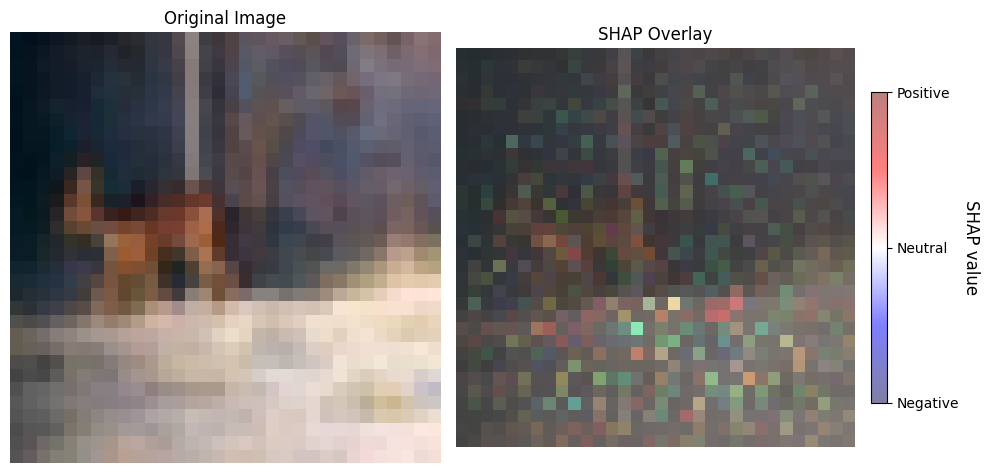

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def custom_shap_visualization(image, shap_values):
    # Ensure the SHAP values are within the range
    # shap_values = np.clip(shap_values, -1.0, 1.0)

    # Normalize the image and SHAP values for visualization
    image_norm = (image - image.min()) / (image.max() - image.min())
    shap_abs_max = np.max(np.abs(shap_values))
    shap_values_norm = shap_values / shap_abs_max

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    ax[0].imshow(image_norm)
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    # SHAP values overlay
    # Use a diverging colormap (e.g., 'seismic', 'coolwarm', etc.)
    # and set the midpoint to 0 for better contrast in positive and negative values
    midpoint = 0 - np.min(shap_values_norm) / (np.max(shap_values_norm) - np.min(shap_values_norm))
    ax[1].imshow(image_norm, alpha=0.7)  # Slightly faded image
    im = ax[1].imshow(shap_values_norm, cmap='seismic', alpha=0.5, vmin=-1, vmax=1)
    ax[1].axis('off')
    ax[1].set_title('SHAP Overlay')

    # Add a colorbar to the SHAP overlay plot
    cbar = fig.colorbar(im, ax=ax[1], fraction=0.036, pad=0.04)
    cbar.set_label('SHAP value', rotation=270, labelpad=15, fontsize=12)
    cbar.set_ticks([-1, 0, 1])
    cbar.ax.set_yticklabels(['Negative', 'Neutral', 'Positive'])

    plt.tight_layout()
    plt.show()

# Usage example assuming selected_correct_examples1 and correct_shap_values are numpy arrays
index = 1  # Replace with the index of the image you want to visualize
image_to_visualize = selected_correct_examples[index]
shap_values_to_visualize = correct_shap_values[0][index]

# Call the custom visualization function
custom_shap_visualization(image_to_visualize, shap_values_to_visualize)


# **Aggregate Analysis of SHAP Values**

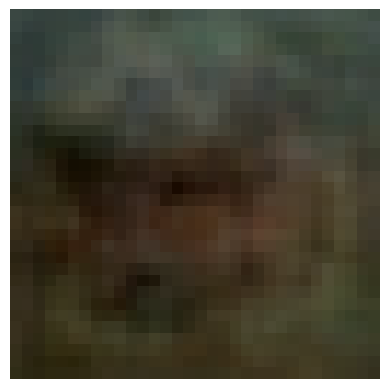

In [ ]:
import numpy as np

# Assuming correct_shap_values is a list of SHAP values for correctly classified images
# and correct_shap_values[0] has the shape (50, 32, 32, 3)

# Calculate the mean of absolute SHAP values across all examples
mean_abs_shap = np.mean(np.abs(correct_shap_values[0]), axis=0)

# mean_abs_shap now has the shape (32, 32, 3), representing the average importance of each pixel
import matplotlib.pyplot as plt

def visualize_aggregated_shap(image, shap_values, alpha=0.6):
    """
    Visualizes aggregated SHAP values on top of the original image.

    Parameters:
    - image: The original image to overlay SHAP values on (mean image or a specific example).
    - shap_values: Aggregated SHAP values to overlay.
    - alpha: Transparency level for the SHAP overlay.
    """
    # Ensure the image is normalized between 0 and 1 for visualization
    image_norm = (image - image.min()) / (image.max() - image.min())

    # Plot original image
    plt.imshow(image_norm)
    plt.axis('off')

    # Overlay SHAP values
    plt.imshow(shap_values, cmap='jet', alpha=alpha)
    plt.show()

# Example: Visualize the mean absolute SHAP values
# For visualization, you might want to use the mean of the images or a representative image
mean_image = np.mean(selected_correct_examples, axis=0)
visualize_aggregated_shap(mean_image, mean_abs_shap)


In [ ]:
# Sum SHAP values across color channels and then take the mean across examples
pixel_importance = np.mean(np.sum(np.abs(correct_shap_values[0]), axis=-1), axis=0)

# pixel_importance now has the shape (32, 32), representing the aggregated importance of each pixel


In [62]:
pixel_importance

array([[0.0005944 , 0.00071234, 0.00090366, ..., 0.00107275, 0.00100434,
        0.00060205],
       [0.0006739 , 0.00131265, 0.00162799, ..., 0.00162833, 0.00141688,
        0.00091956],
       [0.00086056, 0.00191296, 0.00233053, ..., 0.00185955, 0.00199415,
        0.00112429],
       ...,
       [0.00120208, 0.00203199, 0.00225434, ..., 0.00344506, 0.00361295,
        0.00227719],
       [0.00111093, 0.00205535, 0.00269334, ..., 0.0038943 , 0.00235804,
        0.0018668 ],
       [0.00059783, 0.00133218, 0.00192111, ..., 0.00277863, 0.0022592 ,
        0.00141125]])

# **Adjust Brightness Based on High SHAP Values for Correct Examples**

Accuracy after brightness adjustment for correct examples at 70% threshold: 62.00%
Accuracy after brightness adjustment for correct examples at 80% threshold: 70.00%
Accuracy after brightness adjustment for correct examples at 90% threshold: 80.00%


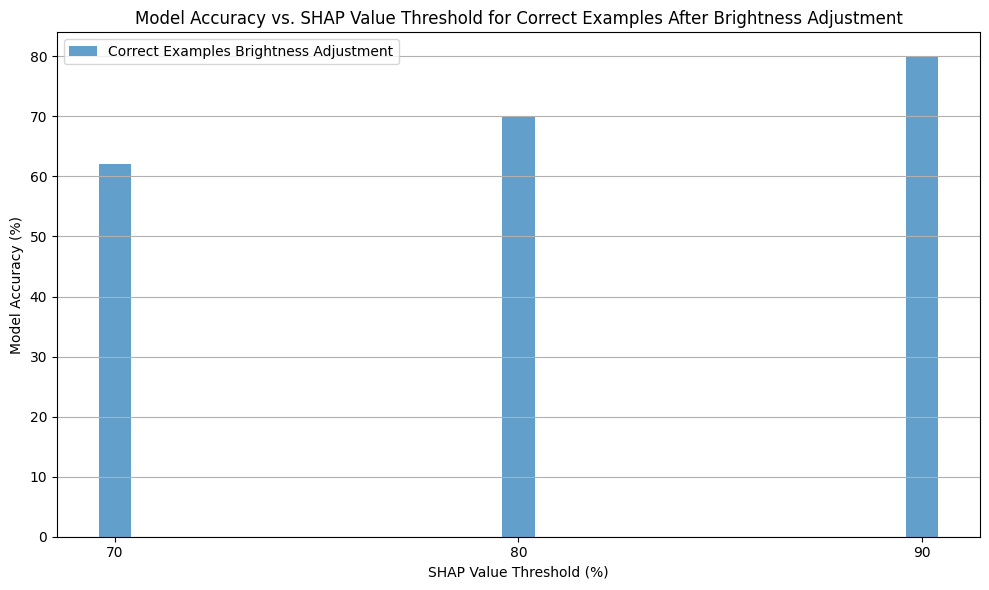

In [100]:
# def get_high_positive_shap_masks_correct(shap_values_correct, thresholds=[70, 80, 90]):
#     """
#     Generates boolean masks for pixels with high positive SHAP values across given thresholds
#     for correct images.

#     Parameters:
#     - shap_values_correct: The SHAP values for the correct images. Assuming shape is (num_images, height, width, channels).
#     - thresholds: List of percentile thresholds to apply.

#     Returns:
#     - A dictionary with keys as thresholds and values as lists of boolean masks for each image.
#     """
#     high_positive_shap_masks_correct = {threshold: [] for threshold in thresholds}

#     # Calculate the magnitude of SHAP values as the sum across channels for simplicity
#     shap_magnitude = np.sum(np.abs(shap_values_correct), axis=-1)

#     for threshold in thresholds:
#         # Determine the cutoff value for each threshold
#         cutoff = np.percentile(shap_magnitude, threshold)

#         # Generate a mask for each image based on the cutoff
#         for i in range(shap_magnitude.shape[0]):
#             mask = shap_magnitude[i] > cutoff
#             high_positive_shap_masks_correct[threshold].append(mask)

#     return high_positive_shap_masks_correct
# # Example SHAP values for correct examples
# # shap_values_correct = [Your SHAP values array here]

# # Generate high positive SHAP masks for correct examples
# thresholds = [70, 80, 90]
# high_positive_shap_masks_correct = get_high_positive_shap_masks_correct(correct_shap_values[0], thresholds)

# def adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks, adjustment_factor=0.5):
#     """
#     Adjusts the brightness of high SHAP value pixels in correct images.

#     Parameters:
#     - correct_images: The correct images to be adjusted.
#     - shap_masks: Boolean masks indicating high SHAP value pixels.
#     - adjustment_factor: Factor to adjust the brightness, <1 to darken, >1 to brighten.

#     Returns:
#     - Array of correct images with adjusted brightness for high SHAP value pixels.
#     """
#     adjusted_images = []
#     for i in range(len(correct_images)):
#         adjusted_image = np.copy(correct_images[i])
#         high_shap_pixels = shap_masks[i]
#         adjusted_image[high_shap_pixels] = np.clip(adjusted_image[high_shap_pixels] * adjustment_factor, 0, 1)
#         adjusted_images.append(adjusted_image)
#     return np.array(adjusted_images)

# def calculate_and_plot_accuracies_brightness_adjustment(correct_images, high_positive_shap_pixels_correct, classifier, selected_labels, thresholds=[70, 80, 90], adjustment_factor=0.5):
#     accuracies = []

#     for threshold in thresholds:
#         shap_masks_correct = high_positive_shap_pixels_correct[threshold]

#         adjusted_images = adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks_correct, adjustment_factor)
#         accuracy = calculate_model_accuracy(classifier, adjusted_images, selected_labels)
#         accuracies.append(accuracy * 100)
#         print(f'Accuracy after brightness adjustment for correct examples at {threshold}% threshold: {accuracy * 100:.2f}%')

#      # Plot the accuracies as a bar chart
#     plt.figure(figsize=(10, 6))
#     plt.bar(thresholds, accuracies, label='Correct Examples Brightness Adjustment', alpha=0.7)
#     plt.xlabel('SHAP Value Threshold (%)')
#     plt.ylabel('Model Accuracy (%)')
#     plt.title('Model Accuracy vs. SHAP Value Threshold for Correct Examples After Brightness Adjustment')
#     plt.xticks(thresholds)
#     plt.grid(axis='y')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# # Assuming `selected_correct_examples`, `high_positive_shap_pixels_correct`, `classifier`, and `selected_labels` are defined
# calculate_and_plot_accuracies_brightness_adjustment(selected_correct_examples,high_positive_shap_masks_correct, classifier, selected_labels)


In [ ]:
def get_high_positive_shap_masks_correct(shap_values_correct, thresholds=[70, 80, 90]):
    """
    Generates boolean masks for pixels with high positive SHAP values across given thresholds
    for correct images.

    Parameters:
    - shap_values_correct: The SHAP values for the correct images. Assuming shape is (num_images, height, width, channels).
    - thresholds: List of percentile thresholds to apply.

    Returns:
    - A dictionary with keys as thresholds and values as lists of boolean masks for each image.
    """
    high_positive_shap_masks_correct = {threshold: [] for threshold in thresholds}

    for threshold in thresholds:
        # Determine the cutoff value for each threshold
        cutoff = np.percentile(shap_values_correct, threshold)

        # Generate a mask for each image based on the cutoff for positive SHAP values
        for i in range(shap_values_correct.shape[0]):
            mask = shap_values_correct[i] > cutoff
            high_positive_shap_masks_correct[threshold].append(mask)

    return high_positive_shap_masks_correct

# Generate high positive SHAP masks for correct examples
thresholds = [70, 80, 90]
high_positive_shap_masks_correct = get_high_positive_shap_masks_correct(correct_shap_values[0], thresholds)

def adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks, adjustment_factor=0.5):
    """
    Adjusts the brightness of high SHAP value pixels in correct images.

    Parameters:
    - correct_images: The correct images to be adjusted.
    - shap_masks: Boolean masks indicating high SHAP value pixels.
    - adjustment_factor: Factor to adjust the brightness, <1 to darken, >1 to brighten.

    Returns:
    - Array of correct images with adjusted brightness for high SHAP value pixels.
    """
    adjusted_images = []
    for i in range(len(correct_images)):
        adjusted_image = np.copy(correct_images[i])
        high_shap_pixels = shap_masks[i]
        adjusted_image[high_shap_pixels] = np.clip(adjusted_image[high_shap_pixels] * adjustment_factor, 0, 1)
        adjusted_images.append(adjusted_image)
    return np.array(adjusted_images)

def calculate_and_plot_accuracies_brightness_adjustment(correct_images, high_positive_shap_pixels_correct, classifier, selected_labels, thresholds=[70, 80, 90], adjustment_factor=0.5):
    accuracies = []

    for threshold in thresholds:
        shap_masks_correct = high_positive_shap_pixels_correct[threshold]

        adjusted_images = adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks_correct, adjustment_factor)
        accuracy = calculate_model_accuracy(classifier, adjusted_images, selected_labels)
        accuracies.append(accuracy * 100)
        print(f'Accuracy after brightness adjustment for correct examples at {threshold}% threshold: {accuracy * 100:.2f}%')

     # Plot the accuracies as a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(thresholds, accuracies, label='Correct Examples Brightness Adjustment', alpha=0.7)
    plt.xlabel('SHAP Value Threshold (%)')
    plt.ylabel('Model Accuracy (%)')
    plt.title('Model Accuracy vs. SHAP Value Threshold for Correct Examples After Brightness Adjustment')
    plt.xticks(thresholds)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming `selected_correct_examples`, `high_positive_shap_masks_correct`, `classifier`, and `selected_labels` are defined
calculate_and_plot_accuracies_brightness_adjustment(selected_correct_examples, high_positive_shap_masks_correct, classifier, selected_labels)


# **Perturb High SHAP Value Pixels in Adversarial Examples**

Accuracy after directly replacing adversarial example pixels for 70% threshold: 38.00%
Accuracy after directly replacing adversarial example pixels for 80% threshold: 20.00%
Accuracy after directly replacing adversarial example pixels for 90% threshold: 16.00%


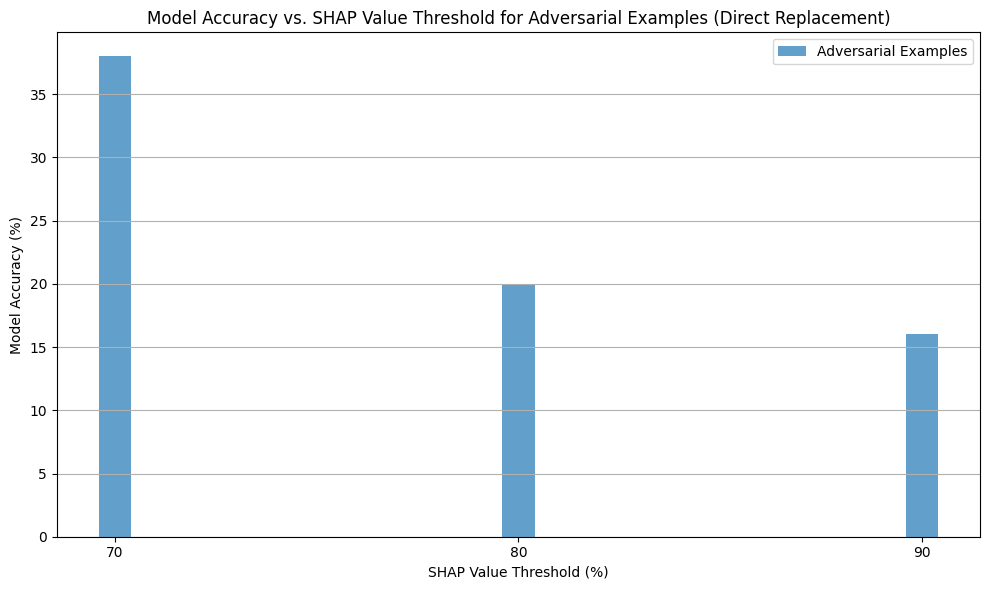

In [102]:

# def get_high_positive_shap_masks(shap_values, thresholds=[70, 80, 90]):
#     """
#     Generates boolean masks for pixels with high positive SHAP values across given thresholds.

#     Parameters:
#     - shap_values: The SHAP values for the images. Assuming shape is (num_images, height, width, channels).
#     - thresholds: List of percentile thresholds to apply.

#     Returns:
#     - A dictionary with keys as thresholds and values as lists of boolean masks for each image.
#     """
#     high_positive_shap_masks = {threshold: [] for threshold in thresholds}

#     # Calculate the magnitude of SHAP values as the sum across channels for simplicity
#     shap_magnitude = np.sum(np.abs(shap_values), axis=-1)

#     for threshold in thresholds:
#         # Determine the cutoff value for each threshold
#         cutoff = np.percentile(shap_magnitude, threshold)

#         # Generate a mask for each image based on the cutoff
#         for i in range(shap_magnitude.shape[0]):
#             mask = shap_magnitude[i] > cutoff
#             high_positive_shap_masks[threshold].append(mask)

#     return high_positive_shap_masks
# thresholds = [70, 80, 90]
# # Replace `shap_values_adversarial.values` with your actual SHAP values array
# high_positive_shap_pixels_adversarial = get_high_positive_shap_masks(adversarial_shap_values[0], thresholds)




# def replace_high_shap_pixels_adversarial(adversarial_images, shap_masks, original_images):
#     """
#     Replaces high SHAP value pixels in adversarial images with the corresponding pixels from original images.

#     Parameters:
#     - adversarial_images: The adversarial images to be perturbed.
#     - shap_masks: Boolean masks indicating high SHAP value pixels.
#     - original_images: The original images for reference.

#     Returns:
#     - Array of adversarial images with high SHAP value pixels replaced by those from the original images.
#     """
#     perturbed_images = []
#     for i in range(len(adversarial_images)):
#         perturbed_image = np.copy(adversarial_images[i])
#         # Directly replace high SHAP value pixels with those from the original image
#         high_shap_pixels = shap_masks[i]
#         perturbed_image[high_shap_pixels] = original_images[i][high_shap_pixels]
#         perturbed_images.append(perturbed_image)
#     return np.array(perturbed_images)
# def calculate_and_plot_accuracies_direct_replacement(adversarial_images, high_positive_shap_pixels_adversarial, original_images, classifier, selected_labels, thresholds=[70, 80, 90]):
#     accuracies = []

#     for threshold in thresholds:
#         shap_masks_adversarial = high_positive_shap_pixels_adversarial[threshold]

#         perturbed_images = replace_high_shap_pixels_adversarial(adversarial_images, shap_masks_adversarial, original_images)
#         accuracy = calculate_model_accuracy(classifier, perturbed_images, selected_labels)
#         accuracies.append(accuracy * 100)
#         print(f'Accuracy after directly replacing adversarial example pixels for {threshold}% threshold: {accuracy * 100:.2f}%')

#     # Plot the accuracies as a bar chart
#     plt.figure(figsize=(10, 6))
#     plt.bar(thresholds, accuracies, label='Adversarial Examples', alpha=0.7)
#     plt.xlabel('SHAP Value Threshold (%)')
#     plt.ylabel('Model Accuracy (%)')
#     plt.title('Model Accuracy vs. SHAP Value Threshold for Adversarial Examples (Direct Replacement)')
#     plt.xticks(thresholds)
#     plt.grid(axis='y')
#     plt.legend()
#     plt.tight_layout()
#     plt.show()
# # Assuming `adversarial_examples`, `high_positive_shap_pixels_adversarial`, `selected_correct_examples`, `classifier`, and `selected_labels` are defined
# calculate_and_plot_accuracies_direct_replacement(x_adv_loaded, high_positive_shap_pixels_adversarial, selected_correct_examples, classifier, selected_labels)


In [ ]:
def get_high_positive_shap_masks(shap_values, thresholds=[70, 80, 90]):
    """
    Generates boolean masks for pixels with high positive SHAP values across given thresholds.

    Parameters:
    - shap_values: The SHAP values for the images. Assuming shape is (num_images, height, width, channels).
    - thresholds: List of percentile thresholds to apply.

    Returns:
    - A dictionary with keys as thresholds and values as lists of boolean masks for each image.
    """
    high_positive_shap_masks = {threshold: [] for threshold in thresholds}

    for threshold in thresholds:
        # Determine the cutoff value for each threshold
        cutoff = np.percentile(shap_values, threshold)

        # Generate a mask for each image based on the cutoff for positive SHAP values
        for i in range(shap_values.shape[0]):
            mask = shap_values[i] > cutoff
            high_positive_shap_masks[threshold].append(mask)

    return high_positive_shap_masks

high_positive_shap_pixels_adversarial = get_high_positive_shap_masks(np.maximum(adversarial_shap_values[0], 0), thresholds)




def replace_high_shap_pixels_adversarial(adversarial_images, shap_masks, original_images):
    """
    Replaces high SHAP value pixels in adversarial images with the corresponding pixels from original images.

    Parameters:
    - adversarial_images: The adversarial images to be perturbed.
    - shap_masks: Boolean masks indicating high SHAP value pixels.
    - original_images: The original images for reference.

    Returns:
    - Array of adversarial images with high SHAP value pixels replaced by those from the original images.
    """
    perturbed_images = []
    for i in range(len(adversarial_images)):
        perturbed_image = np.copy(adversarial_images[i])
        # Directly replace high SHAP value pixels with those from the original image
        high_shap_pixels = shap_masks[i]
        perturbed_image[high_shap_pixels] = original_images[i][high_shap_pixels]
        perturbed_images.append(perturbed_image)
    return np.array(perturbed_images)
def calculate_and_plot_accuracies_direct_replacement(adversarial_images, high_positive_shap_pixels_adversarial, original_images, classifier, selected_labels, thresholds=[70, 80, 90]):
    accuracies = []

    for threshold in thresholds:
        shap_masks_adversarial = high_positive_shap_pixels_adversarial[threshold]

        perturbed_images = replace_high_shap_pixels_adversarial(adversarial_images, shap_masks_adversarial, original_images)
        accuracy = calculate_model_accuracy(classifier, perturbed_images, selected_labels)
        accuracies.append(accuracy * 100)
        print(f'Accuracy after directly replacing adversarial example pixels for {threshold}% threshold: {accuracy * 100:.2f}%')

    # Plot the accuracies as a bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(thresholds, accuracies, label='Adversarial Examples', alpha=0.7)
    plt.xlabel('SHAP Value Threshold (%)')
    plt.ylabel('Model Accuracy (%)')
    plt.title('Model Accuracy vs. SHAP Value Threshold for Adversarial Examples (Direct Replacement)')
    plt.xticks(thresholds)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.show()
# Assuming `adversarial_examples`, `high_positive_shap_pixels_adversarial`, `selected_correct_examples`, `classifier`, and `selected_labels` are defined
calculate_and_plot_accuracies_direct_replacement(x_adv_loaded, high_positive_shap_pixels_adversarial, selected_correct_examples, classifier, selected_labels)


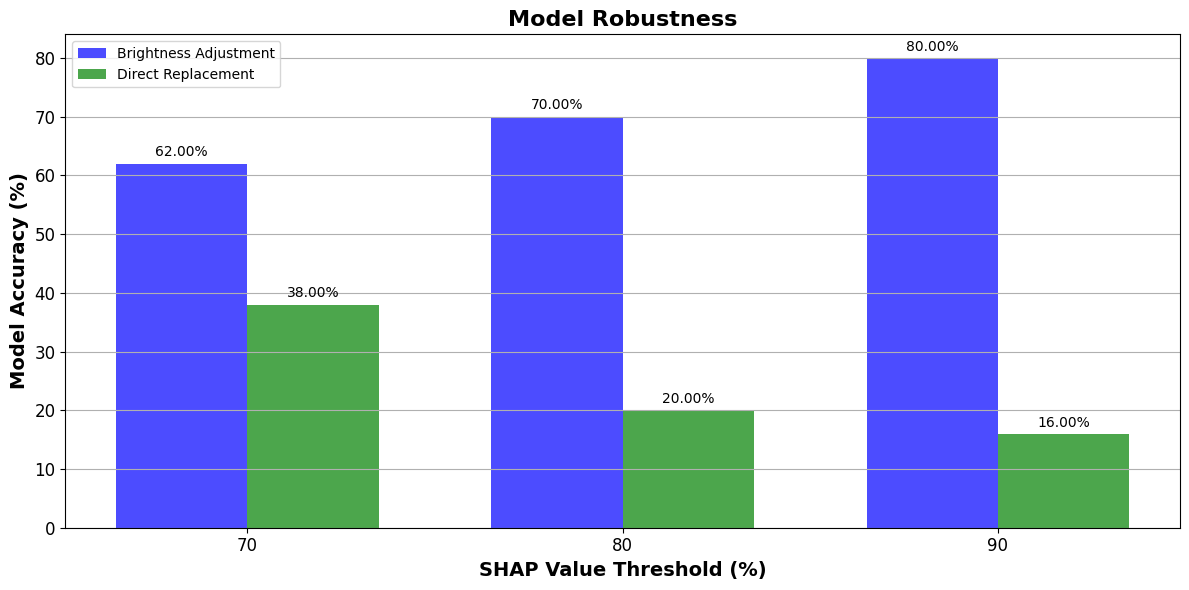

In [116]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_and_plot_accuracies_combined(correct_images, high_positive_shap_pixels_correct, adversarial_images, high_positive_shap_pixels_adversarial, original_images, classifier, selected_labels, thresholds=[70, 80, 90], adjustment_factor=0.5):
    brightness_accuracies = []
    direct_replacement_accuracies = []

    for threshold in thresholds:
        shap_masks_correct = high_positive_shap_pixels_correct[threshold]
        adjusted_images = adjust_brightness_for_high_shap_pixels_correct(correct_images, shap_masks_correct, adjustment_factor)
        brightness_accuracy = calculate_model_accuracy(classifier, adjusted_images, selected_labels)
        brightness_accuracies.append(brightness_accuracy * 100)

        shap_masks_adversarial = high_positive_shap_pixels_adversarial[threshold]
        perturbed_images = replace_high_shap_pixels_adversarial(adversarial_images, shap_masks_adversarial, original_images)
        direct_replacement_accuracy = calculate_model_accuracy(classifier, perturbed_images, selected_labels)
        direct_replacement_accuracies.append(direct_replacement_accuracy * 100)

    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(thresholds))

    # Create bar plots and add annotations
    brightness_bars = plt.bar(index, brightness_accuracies, bar_width, label='Brightness Adjustment', color='b', alpha=0.7)
    direct_replacement_bars = plt.bar(index + bar_width, direct_replacement_accuracies, bar_width, label='Direct Replacement', color='g', alpha=0.7)

    # Add annotations above each bar
    for bar in brightness_bars + direct_replacement_bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}%',  # Display the accuracy value with two decimal places
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # Offset for the text position
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=10)

    plt.xlabel('SHAP Value Threshold (%)', fontsize=14, fontweight='bold')
    plt.ylabel('Model Accuracy (%)', fontsize=14, fontweight='bold')
    plt.title('Model Robustness', fontsize=16, fontweight='bold')
    plt.xticks(index + bar_width / 2, thresholds, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y')
    plt.legend()
    plt.tight_layout()
    plt.savefig("shapmodelrobustness.png")
    plt.show()

# Assuming input data and parameters are defined for selected_correct_examples, high_positive_shap_masks_correct, x_adv_loaded, high_positive_shap_pixels_adversarial, classifier, and selected_labels
calculate_and_plot_accuracies_combined(selected_correct_examples, high_positive_shap_masks_correct, x_adv_loaded, high_positive_shap_pixels_adversarial, selected_correct_examples, classifier, selected_labels)


# **Step 1: Complete Testing Framework**

Original test data (1000 images):
Correctly classified: 9241
Incorrectly classified: 759
Accuracy (Noisy): 0.80
Accuracy (Rotated): 0.24
Accuracy (Brightness Adjusted): 0.94
Image 1 (Noisy Perturbation): True Label = 8, Predicted Label = 8
Image 2 (Noisy Perturbation): True Label = 0, Predicted Label = 0
Image 3 (Noisy Perturbation): True Label = 7, Predicted Label = 7
Image 4 (Noisy Perturbation): True Label = 9, Predicted Label = 9
Image 5 (Noisy Perturbation): True Label = 8, Predicted Label = 8
Image 6 (Noisy Perturbation): True Label = 8, Predicted Label = 8
Image 7 (Noisy Perturbation): True Label = 3, Predicted Label = 3
Image 8 (Noisy Perturbation): True Label = 6, Predicted Label = 6
Image 9 (Noisy Perturbation): True Label = 2, Predicted Label = 6
Image 10 (Noisy Perturbation): True Label = 4, Predicted Label = 4
Image 11 (Noisy Perturbation): True Label = 2, Predicted Label = 2
Image 12 (Noisy Perturbation): True Label = 1, Predicted Label = 6
Image 13 (Noisy Perturbation): 

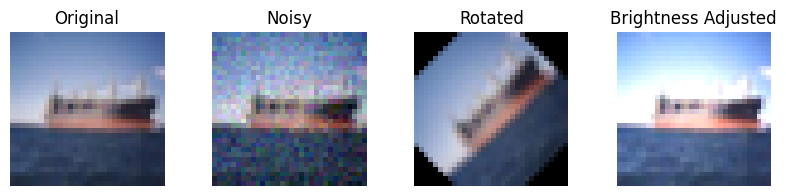

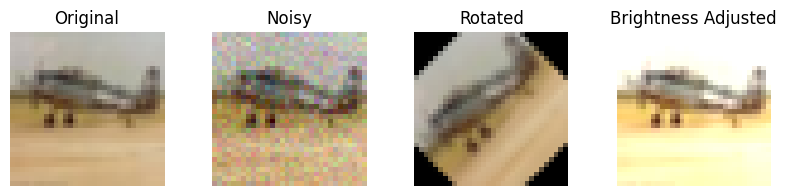

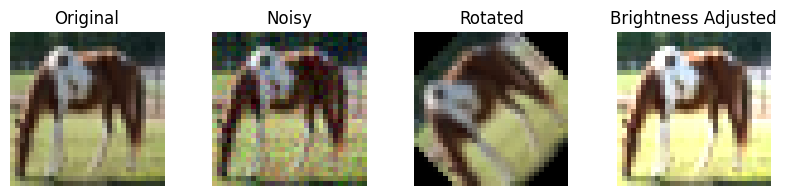

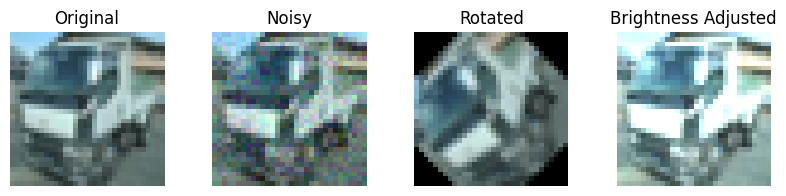

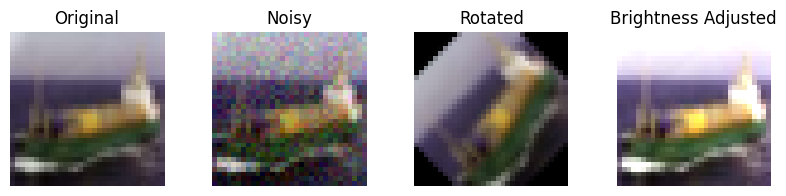

Accuracy for 10% Noisy Perturbation: 38.00
Accuracy for 20% Noisy Perturbation: 22.00
Accuracy for 50% Noisy Perturbation: 24.00
Accuracy for 10% Rotated Perturbation: 22.00
Accuracy for 20% Rotated Perturbation: 14.00
Accuracy for 50% Rotated Perturbation: 10.00
Accuracy for 10% Brightness Adjusted Perturbation: 68.00
Accuracy for 20% Brightness Adjusted Perturbation: 50.00
Accuracy for 50% Brightness Adjusted Perturbation: 24.00


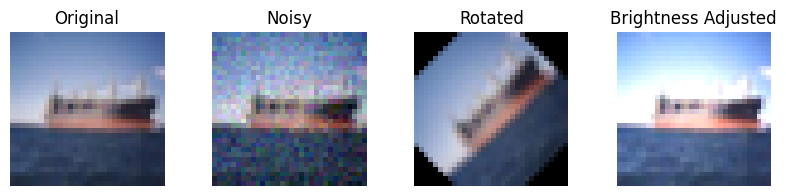

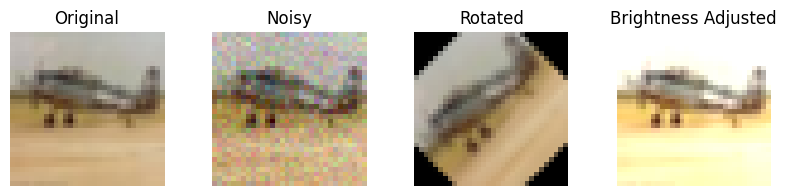

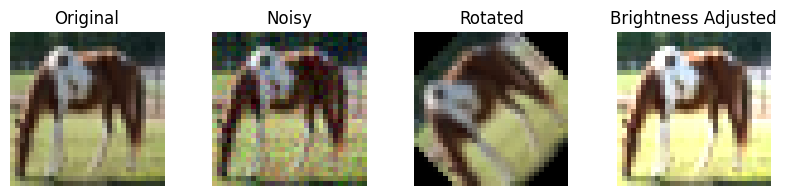

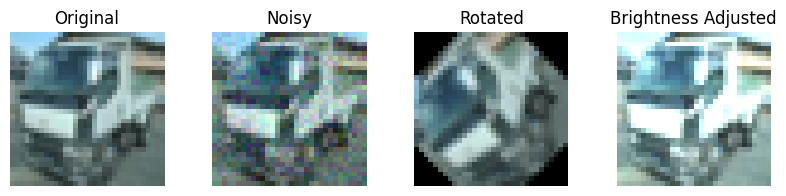

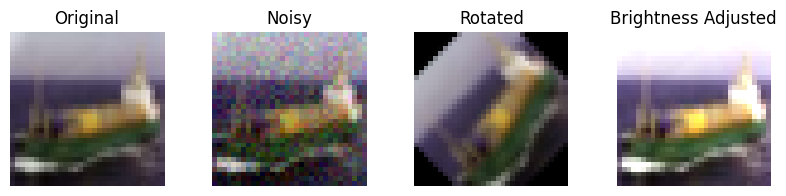

Accuracy for 10% brightness change: 74.00%
Accuracy for 20% brightness change: 50.00%
Accuracy for 30% brightness change: 24.00%


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Perturbing 102 pixels out of 1024 (10%) for image 1
Perturbing 102 pixels out of 1024 (10%) for image 2
Perturbing 102 pixels out of 1024 (10%) for image 3
Perturbing 102 pixels out of 1024 (10%) for image 4
Perturbing 102 pixels out of 1024 (10%) for image 5
Perturbing 102 pixels out of 1024 (10%) for image 6
Perturbing 102 pixels out of 1024 (10%) for image 7
Perturbing 102 pixels out of 1024 (10%) for image 8
Perturbing 102 pixels out of 1024 (10%) for image 9
Perturbing 102 pixels out of 1024 (10%) for image 10
Perturbing 102 pixels out of 1024 (10%) for image 11
Perturbing 102 pixels out of 1024 (10%) for image 12
Perturbing 102 pixels out of 1024 (10%) for image 13
Perturbing 102 pixels out of 1024 (10%) for image 14
Perturbing 102 pixels out of 1024 (10%) for image 15
Perturbing 102 pixels out of 1024 (10%) for image 16
Perturbing 102 pixels out of 1024 (10%) for image 17
Perturbing 102 pixels out of 1024 (10%) for image 18
Perturbing 102 pixels out of 1024 (10%) for image 19
Pe

In [ ]:
import numpy as np
import cv2

from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import pickle
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.estimators.classification import TensorFlowV2Classifier  # Adjust based on your model framework

# ====================
# Step 1: Load Model
# ====================

# Load pre-trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/CIFAR/cifar_resnet.h5')
classifier_model = model
# classifier_model = load_model(path)
classifier = KerasClassifier(clip_values=(min_, max_), model=classifier_model, use_logits=False,
                             preprocessing=(0.5, 1))

x_test_pred = np.argmax(classifier.predict(x_test), axis=1)
true_labels = np.argmax(y_test, axis=1)

# Identify correctly classified examples
correct_indices = np.where(x_test_pred == true_labels)[0]
correct_examples = x_test[correct_indices]
correct_labels = y_test[correct_indices]

# Count correctly and incorrectly classified examples
nb_correct_pred = len(correct_indices)
nb_incorrect_pred = len(x_test) - nb_correct_pred

print("Original test data (1000 images):")
print("Correctly classified: {}".format(nb_correct_pred))
print("Incorrectly classified: {}".format(nb_incorrect_pred))

# Optionally, save the correctly classified examples and labels
# np.save('correct_examples.npy', correct_examples)
# np.save('correct_labels.npy', correct_labels)

# ==================================
# Step 2: Define Perturbation Functions
# ==================================
# Function to add Gaussian noise to an image
def add_noise(image):
    noise = np.random.normal(0, 0.05, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image

# Function to rotate an image by a given angle
def rotate_image(image, angle):
    center = (image.shape[1] // 2, image.shape[0] // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    return rotated_image

# Function to adjust the brightness of an image
def adjust_brightness(image, factor):
    bright_image = np.clip(image * factor, 0, 1)
    return bright_image

# Function to apply a specified perturbation to all images in a dataset
def apply_perturbation_to_all_images(images, perturbation_func, **kwargs):
    perturbed_images = np.array([perturbation_func(image, **kwargs) for image in images])
    return perturbed_images

# ================================
# Step 3: Apply Perturbations and Evaluate Model
# ================================

# Define the number of examples to select per class
examples_per_class = 10  # 100 examples (50 correct, 50 adversarial) per class for a total of 1000 examples

# Initialize empty lists to store selected examples and labels
selected_correct_examples = []
selected_labels = []  # New list to store corresponding class labels

# Initialize dictionaries to keep track of selected examples per class
selected_examples_per_class_correct = {}


# Shuffle the indices to randomly select examples
shuffled_indices = np.arange(len(correct_examples))
np.random.shuffle(shuffled_indices)

# Iterate through shuffled indices
for idx in shuffled_indices:
    correct_example = correct_examples[idx]
    correct_label = np.argmax(correct_labels[idx])  # Convert one-hot encoding to integer label


    # Check if the class (as an integer) is already present in selected_examples_per_class
    if correct_label not in selected_examples_per_class_correct:
        selected_examples_per_class_correct[correct_label] = 0


    # Check if we have selected enough examples for this class
    if (
        selected_examples_per_class_correct[correct_label] < examples_per_class // 2
    ):
        selected_examples_per_class_correct[correct_label] += 1
        selected_labels.append(correct_label)  # Add the corresponding label
        selected_correct_examples.append(correct_example)

    # Check if we have selected enough examples overall
    if len(selected_labels) == examples_per_class * len(selected_examples_per_class_correct):
        break

# Convert selected examples and labels to NumPy arrays
selected_correct_examples = np.array(selected_correct_examples)
selected_labels = np.array(selected_labels)


# List to store debugging information
debug_info = []

# Apply different perturbations to the dataset
all_correct_noisy = apply_perturbation_to_all_images(selected_correct_examples, add_noise)
all_correct_rotated = apply_perturbation_to_all_images(selected_correct_examples, rotate_image, angle=45)
all_correct_bright = apply_perturbation_to_all_images(selected_correct_examples, adjust_brightness, factor=1.5)

# Example of using ImageDataGenerator for augmentation (optional)
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                             shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

# Convert labels to categorical if using ImageDataGenerator
selected_labels_categorical = to_categorical(selected_labels, 10)

# =============================
# Step 4: Calculate Model Accuracy
# =============================
# Define a function to calculate accuracy based on model predictions and true labels
def calculate_model_accuracy(model, images, true_labels):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

# Calculate accuracies for different perturbation types
accuracy_noisy = calculate_model_accuracy(classifier, all_correct_noisy, selected_labels)
accuracy_rotated = calculate_model_accuracy(classifier,all_correct_rotated, selected_labels)
accuracy_bright = calculate_model_accuracy(classifier, all_correct_bright, selected_labels)

# Print out accuracies for each perturbation type
print(f"Accuracy (Noisy): {accuracy_noisy:.2f}")
print(f"Accuracy (Rotated): {accuracy_rotated:.2f}")
print(f"Accuracy (Brightness Adjusted): {accuracy_bright:.2f}")

# =============================
# Step 5: Debugging and Documentation
# =============================
# Debugging and documentation involve inspecting model predictions, logging results,
# and potentially visualizing the effects of perturbations.

# Debugging for Noisy Perturbations
for i, perturbed_image in enumerate(all_correct_noisy):
    true_label = selected_labels[i]
    predicted_label = np.argmax(classifier.predict(np.expand_dims(perturbed_image, axis=0)))
    debug_info.append(f"Image {i+1} (Noisy Perturbation): True Label = {true_label}, Predicted Label = {predicted_label}")

# Debugging for Rotated Perturbations
for i, perturbed_image in enumerate(all_correct_rotated):
    true_label = selected_labels[i]
    predicted_label = np.argmax(classifier.predict(np.expand_dims(perturbed_image, axis=0)))
    debug_info.append(f"Image {i+1} (Rotated Perturbation): True Label = {true_label}, Predicted Label = {predicted_label}")

# Debugging for Brightness Adjusted Perturbations
for i, perturbed_image in enumerate(all_correct_bright):
    true_label = selected_labels[i]
    predicted_label = np.argmax(classifier.predict(np.expand_dims(perturbed_image, axis=0)))
    debug_info.append(f"Image {i+1} (Brightness Adjusted Perturbation): True Label = {true_label}, Predicted Label = {predicted_label}")

# Print debugging information
for info in debug_info:
    print(info)

# Visualize perturbed images for inspection
import matplotlib.pyplot as plt

def visualize_images(image_list, title_list, figsize=(20, 10), num_examples=5):
    """
    Visualizes a limited number of images with corresponding titles.

    Parameters:
    - image_list: List of images to be displayed.
    - title_list: List of titles for each image.
    - figsize: Tuple indicating figure size.
    - num_examples: The number of examples to display (default is 5).
    """
    # Ensure we do not exceed the list size or the desired number of examples
    n = min(len(image_list), num_examples)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(image_list[i])
        plt.title(title_list[i])
        plt.axis('off')
    plt.show()

# Example usage with 5 examples
# Generate or select 5 specific examples and their titles
example_indices = [0, 1, 2, 3, 4]  # Just as an example, select the first 5 indices
selected_images = [selected_correct_examples[i] for i in example_indices]
noisy_images = [all_correct_noisy[i] for i in example_indices]
rotated_images = [all_correct_rotated[i] for i in example_indices]
brightness_adjusted_images = [all_correct_bright[i] for i in example_indices]

# Display each type of image modification in sequence for comparison
for i in range(len(example_indices)):
    visualize_images(
        [selected_images[i], noisy_images[i], rotated_images[i], brightness_adjusted_images[i]],
        ["Original", "Noisy", "Rotated", "Brightness Adjusted"],
        figsize=(10, 2)  # Adjust figure size as needed for visibility
    )


# ================================
# Step 6: Coverage Analysis and Test Case Completion
# ================================
# Define a function to randomly change brightness of pixels
def adjust_brightness_random_pixels(image, percentage_change):
    perturbed_image = np.copy(image)
    height, width, channels = image.shape
    num_pixels = int(percentage_change * height * width / 100)
    pixel_positions = np.random.choice(height * width, num_pixels, replace=False)

    for pixel_position in pixel_positions:
        row = pixel_position // width
        col = pixel_position % width
        perturbed_image[row, col] = np.clip(perturbed_image[row, col] * 0.5, 0, 1)

    return perturbed_image

def coverage_analysis(images, labels, perturbation_type):
    percentage_changes = [10, 20, 50]
    accuracies = []

    for percentage in percentage_changes:
        perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in images]
        accuracy = calculate_model_accuracy(classifier, np.array(perturbed_images), labels)
        accuracies.append(accuracy)

    for i, percentage in enumerate(percentage_changes):
        print(f'Accuracy for {percentage}% {perturbation_type} Perturbation: {accuracies[i] * 100:.2f}')

# Perform coverage analysis for all perturbation types
coverage_analysis(all_correct_noisy, selected_labels, 'Noisy')
coverage_analysis(all_correct_rotated, selected_labels, 'Rotated')
coverage_analysis(all_correct_bright, selected_labels, 'Brightness Adjusted')

# =============================
# Step 7: Debugging and Documentation (Continued)
# =============================
# Visualize perturbed images for inspection
import matplotlib.pyplot as plt
def visualize_images(image_list, title_list, figsize=(20, 10), num_examples=5):
    """
    Visualizes a limited number of images with corresponding titles.

    Parameters:
    - image_list: List of images to be displayed.
    - title_list: List of titles for each image.
    - figsize: Tuple indicating figure size.
    - num_examples: The number of examples to display (default is 5).
    """
    # Ensure we do not exceed the list size or the desired number of examples
    n = min(len(image_list), num_examples)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(image_list[i])
        plt.title(title_list[i])
        plt.axis('off')
    plt.show()

# Example usage with 5 examples
# Generate or select 5 specific examples and their titles
example_indices = [0, 1, 2, 3, 4]  # Just as an example, select the first 5 indices
selected_images = [selected_correct_examples[i] for i in example_indices]
noisy_images = [all_correct_noisy[i] for i in example_indices]
rotated_images = [all_correct_rotated[i] for i in example_indices]
brightness_adjusted_images = [all_correct_bright[i] for i in example_indices]

# Display each type of image modification in sequence for comparison
for i in range(len(example_indices)):
    visualize_images(
        [selected_images[i], noisy_images[i], rotated_images[i], brightness_adjusted_images[i]],
        ["Original", "Noisy", "Rotated", "Brightness Adjusted"],
        figsize=(10, 2)  # Adjust figure size as needed for visibility
    )



# =============================
# Step 8: Calculate Model Accuracy (Continued)
# =============================
# ... (Continued accuracy calculation code here)

# =============================
# Step 9: Debugging and Documentation (Continued)
# =============================
# ... (Continued debugging and documentation as needed)

# =============================
# Step 10: Summary and Next Steps
# =============================


# Example usage:
percentage_changes = [10, 20, 30]
accuracies = []

for percentage in percentage_changes:
    perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in selected_correct_examples]
    accuracy = calculate_model_accuracy(classifier,np.array(perturbed_images), selected_labels)
    accuracies.append(accuracy)

for i, percentage in enumerate(percentage_changes):
    print(f'Accuracy for {percentage}% brightness change: {accuracies[i] * 100:.2f}%')

# =============================
# Step 11:Genarte Adversarial Examples
# =============================
#########

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import pickle
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.estimators.classification import TensorFlowV2Classifier  # Adjust based on your model framework


# List of attacks to be evaluated
attacks = [ProjectedGradientDescent]

# Define the range of eps values
eps_range = [0.03]
results = []
def perform_and_save_attack(attack_class, eps, x_examples, y_true, classifier, attack_name):
    """
    Perform an attack, return the accuracy, adversarial examples, and true labels, and save the adversarial examples with labels.
    """
    attack = attack_class(classifier, eps=eps)
    x_adv = attack.generate(x=x_examples)
    y_pred_adv = np.argmax(classifier.predict(x_adv), axis=1)

    if len(y_true.shape) > 1 and y_true.shape[1] > 1:
        y_true_flat = np.argmax(y_true, axis=1)
    else:
        y_true_flat = y_true

    accuracy_adv = accuracy_score(y_true_flat, y_pred_adv)

    # Save the adversarial examples and their true labels
    save_path = f'/content/drive/MyDrive/ColabNotebooks/CIFAR/{attack_name}_eps_{eps}.pkl'
    with open(save_path, 'wb') as f:
        pickle.dump({'x_adv': x_adv, 'y_true': y_true}, f)

    return accuracy_adv, x_adv, y_true

# Dictionary to store adversarial examples and labels
adversarial_data = {}

# Evaluate each attack at each epsilon value and save the adversarial examples
for attack in attacks:
    for eps in eps_range:
        accuracy_adv, x_adv, y_true_adv = perform_and_save_attack(attack, eps, selected_correct_examples, selected_labels, classifier, attack.__name__)
        results.append({
            'Attack': attack.__name__,
            'Epsilon': eps,
            'Accuracy': accuracy_adv
        })
        # Storing adversarial examples and labels in the dictionary
        adversarial_data[f'{attack.__name__}_eps_{eps}'] = {'x_adv': x_adv, 'y_true': y_true_adv}

# Now, `adversarial_data` contains all the adversarial examples and labels for further use
import pickle

def load_adversarial_data(file_path):
    """
    Load adversarial examples and labels from a pickle file.

    Parameters:
    - file_path: The path to the pickle file containing the saved adversarial examples and labels.

    Returns:
    - A dictionary with keys 'x_adv' and 'y_true' corresponding to the adversarial examples and their true labels.
    """
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Example usage
file_path = '/content/drive/MyDrive/ColabNotebooks/CIFAR/ProjectedGradientDescent_eps_0.03.pkl'
loaded_data = load_adversarial_data(file_path)

# Accessing the adversarial examples and labels
x_adv_loaded = loaded_data['x_adv']
y_true_loaded = loaded_data['y_true']
#########
# Define the percentage of pixels to perturb
percentages = [10, 20, 30]

import numpy as np

def perturb_adversarial_with_original(adversarial_images, original_images, percentage):
    perturbed_images = []
    height, width = 32, 32  # Explicitly set for clarity, based on provided shapes

    for i in range(adversarial_images.shape[0]):
        adversarial_image = np.copy(adversarial_images[i])
        original_image = original_images[i]
        num_pixels = height * width  # 32 * 32 = 1024, as confirmed
        num_perturbed_pixels = int(percentage / 100 * num_pixels)

        # Debug: Print the number of pixels to be perturbed
        print(f"Perturbing {num_perturbed_pixels} pixels out of {num_pixels} ({percentage}%) for image {i+1}")

        # Generating unique pixel positions for perturbation
        pixel_positions = np.random.choice(num_pixels, num_perturbed_pixels, replace=False)

        for pixel_position in pixel_positions:
            # Calculating row and column indices based on the flat pixel position
            row = pixel_position // width
            col = pixel_position % width

            # Safety check to catch any potential index error before it occurs
            if row >= height or col >= width:
                print(f"Out of bounds access attempt: Row {row}, Col {col}")
                continue  # Skip this iteration to avoid the IndexError

            adversarial_image[row, col, :] = original_image[row, col, :]

        perturbed_images.append(adversarial_image)

    return np.array(perturbed_images)


percentage_changes = [10, 20, 30]

for percentage in percentage_changes:
    perturbed_adversarial = perturb_adversarial_with_original(x_adv_loaded, selected_correct_examples, percentage)
    predictions = classifier.predict(perturbed_adversarial, axis=1)

    correct_labels = selected_labels  # Ensure this matches the true labels accurately.
    predicted_labels = np.argmax(predictions, axis=1)
    print(f"Predictions ({percentage}% perturbation): {predicted_labels}")

    # Calculate accuracy and print it
    accuracy = accuracy_score(correct_labels, predicted_labels)
    print(f"Accuracy ({percentage}% Perturbation): {accuracy * 100:.2f}%")

    # Debug: Check if perturbation changes the distribution of predictions
    unique, counts = np.unique(predicted_labels, return_counts=True)
    print(f"Distribution of predicted labels for {percentage}% perturbation: {dict(zip(unique, counts))}")

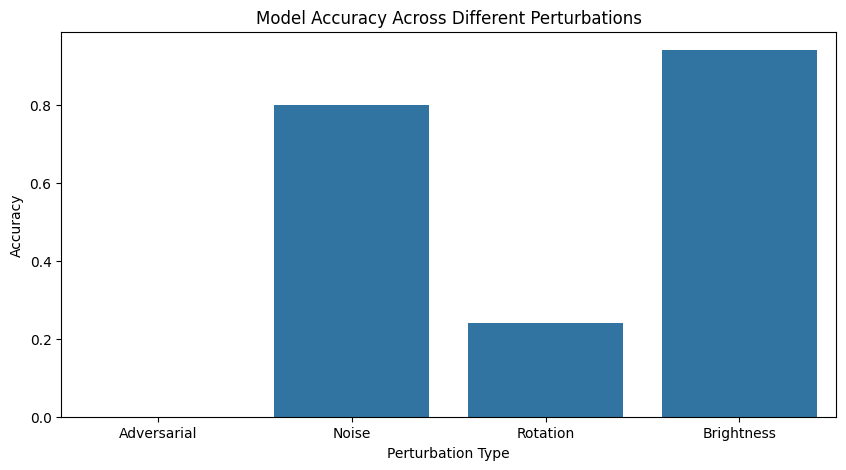

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'accuracies' contains accuracy scores for different perturbations
perturbations = ['Adversarial', 'Noise', 'Rotation', 'Brightness']
accuracies = [accuracy_adv, accuracy_noisy, accuracy_rotated, accuracy_bright]  # Example values

plt.figure(figsize=(10, 5))
sns.barplot(x=perturbations, y=accuracies)
plt.xlabel('Perturbation Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Across Different Perturbations')
plt.show()


In [ ]:
def coverage_analysis(images, labels, perturbation_type):
    percentage_changes = [10, 20, 30]
    accuracies = []

    for percentage in percentage_changes:
        perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in images]
        accuracy = calculate_model_accuracy(classifier, np.array(perturbed_images), labels)
        accuracies.append(accuracy)

    for i, percentage in enumerate(percentage_changes):
        print(f'Accuracy for {percentage}% {perturbation_type} Perturbation: {accuracies[i] * 100:.2f}')

# Perform coverage analysis for all perturbation types
coverage_analysis(all_correct_noisy, selected_labels, 'Noisy')
coverage_analysis(all_correct_rotated, selected_labels, 'Rotated')
coverage_analysis(all_correct_bright, selected_labels, 'Brightness Adjusted')



Accuracy for 10% Noisy Perturbation: 38.00
Accuracy for 20% Noisy Perturbation: 26.00
Accuracy for 30% Noisy Perturbation: 22.00
Accuracy for 10% Rotated Perturbation: 28.00
Accuracy for 20% Rotated Perturbation: 18.00
Accuracy for 30% Rotated Perturbation: 12.00
Accuracy for 10% Brightness Adjusted Perturbation: 66.00
Accuracy for 20% Brightness Adjusted Perturbation: 44.00
Accuracy for 30% Brightness Adjusted Perturbation: 24.00


In [ ]:
noisy_accuracies = coverage_analysis(all_correct_noisy, selected_labels, 'Noisy')
rotated_accuracies = coverage_analysis(all_correct_rotated, selected_labels, 'Rotated')
bright_accuracies = coverage_analysis(all_correct_bright, selected_labels, 'Brightness Adjusted')



Accuracy for 10% Noisy Perturbation: 46.00
Accuracy for 20% Noisy Perturbation: 26.00
Accuracy for 30% Noisy Perturbation: 22.00
Accuracy for 10% Rotated Perturbation: 30.00
Accuracy for 20% Rotated Perturbation: 14.00
Accuracy for 30% Rotated Perturbation: 12.00
Accuracy for 10% Brightness Adjusted Perturbation: 62.00
Accuracy for 20% Brightness Adjusted Perturbation: 48.00
Accuracy for 30% Brightness Adjusted Perturbation: 28.00


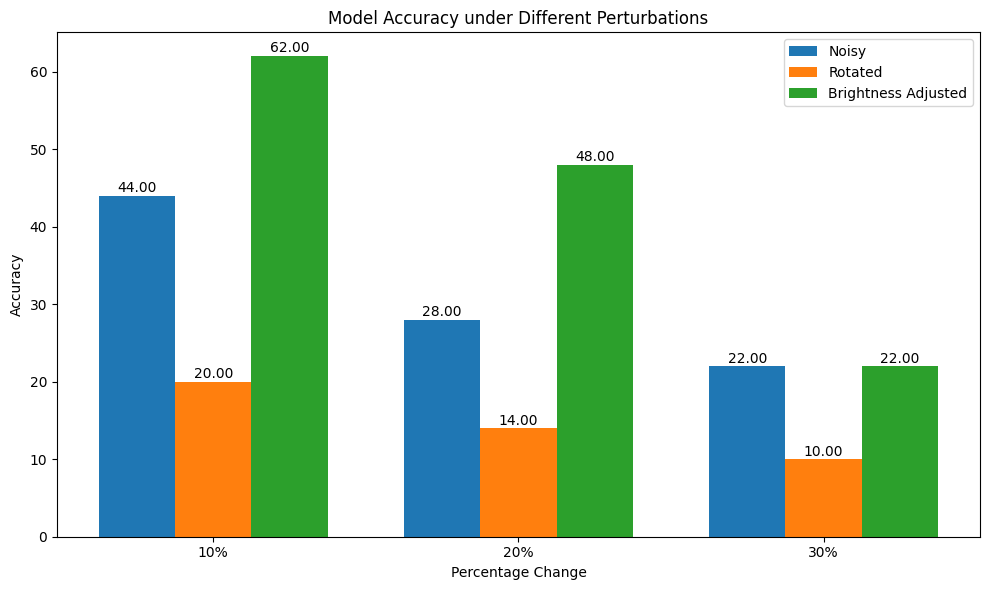

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming percentage_changes and accuracies are already defined
percentage_changes = [10, 20, 30]
noisy_accuracies = [44.00, 28.00, 22.00]  # Example accuracies
rotated_accuracies = [20.00, 14.00, 10.00]
bright_accuracies = [ 62.00, 48.00, 22.00]

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.25
indices = np.arange(len(percentage_changes))

# Plot each accuracy list
bars_noisy = plt.bar(indices, noisy_accuracies, bar_width, label='Noisy')
bars_rotated = plt.bar(indices + bar_width, rotated_accuracies, bar_width, label='Rotated')
bars_bright = plt.bar(indices + 2 * bar_width, bright_accuracies, bar_width, label='Brightness Adjusted')

# Function to add annotations on bars
def add_annotations(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2., 1.002*height, f'{height:.2f}', ha='center', va='bottom')

# Add some labels and title
plt.xlabel('Percentage Change')
plt.ylabel('Accuracy')
plt.title('Model Accuracy under Different Perturbations')
plt.xticks(indices + bar_width, [f'{pc}%' for pc in percentage_changes])

# Call the function to add annotations on each set of bars
add_annotations(bars_noisy)
add_annotations(bars_rotated)
add_annotations(bars_bright)

plt.legend()
plt.tight_layout()
plt.show()


In [113]:


def adjust_brightness_random_pixels(image, percentage_change):
    perturbed_image = np.copy(image)
    height, width, channels = image.shape
    num_pixels = int(percentage_change * height * width / 100)
    pixel_positions = np.random.choice(height * width, num_pixels, replace=False)

    for pixel_position in pixel_positions:
        row = pixel_position // width
        col = pixel_position % width
        perturbed_image[row, col] = np.clip(perturbed_image[row, col] * 0.5, 0, 1)

    return perturbed_image

# Example usage:
percentage_changes = [10, 20, 30]
accuracies = []

for percentage in percentage_changes:
    perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in selected_correct_examples]
    accuracy = calculate_model_accuracy(classifier,np.array(perturbed_images), selected_labels)
    accuracies.append(accuracy)

for i, percentage in enumerate(percentage_changes):
    print(f'Accuracy for {percentage}% brightness change: {accuracies[i] * 100:.2f}%')



percentages = [10, 20, 30]

import numpy as np

def perturb_adversarial_with_original(adversarial_images, original_images, percentage):
    perturbed_images = []
    height, width = 32, 32  # Explicitly set for clarity, based on provided shapes

    for i in range(adversarial_images.shape[0]):
        adversarial_image = np.copy(adversarial_images[i])
        original_image = original_images[i]
        num_pixels = height * width  # 32 * 32 = 1024, as confirmed
        num_perturbed_pixels = int(percentage / 100 * num_pixels)

        # Debug: Print the number of pixels to be perturbed
        # print(f"Perturbing {num_perturbed_pixels} pixels out of {num_pixels} ({percentage}%) for image {i+1}")

        # Generating unique pixel positions for perturbation
        pixel_positions = np.random.choice(num_pixels, num_perturbed_pixels, replace=False)

        for pixel_position in pixel_positions:
            # Calculating row and column indices based on the flat pixel position
            row = pixel_position // width
            col = pixel_position % width

            # Safety check to catch any potential index error before it occurs
            if row >= height or col >= width:
                print(f"Out of bounds access attempt: Row {row}, Col {col}")
                continue  # Skip this iteration to avoid the IndexError

            adversarial_image[row, col, :] = original_image[row, col, :]

        perturbed_images.append(adversarial_image)

    return np.array(perturbed_images)


percentage_changes = [10, 20, 30]

for percentage in percentage_changes:
    perturbed_adversarial = perturb_adversarial_with_original(x_adv_loaded, selected_correct_examples, percentage)
    predictions = classifier.predict(perturbed_adversarial, axis=1)

    correct_labels = selected_labels  # Ensure this matches the true labels accurately.
    predicted_labels = np.argmax(predictions, axis=1)
    print(f"Predictions ({percentage}% perturbation): {predicted_labels}")

    # Calculate accuracy and print it
    accuracy = accuracy_score(correct_labels, predicted_labels)
    print(f"Accuracy ({percentage}% Perturbation): {accuracy * 100:.2f}%")

    # Debug: Check if perturbation changes the distribution of predictions
    unique, counts = np.unique(predicted_labels, return_counts=True)
    print(f"Distribution of predicted labels for {percentage}% perturbation: {dict(zip(unique, counts))}")

Accuracy for 10% brightness change: 70.00%
Accuracy for 20% brightness change: 52.00%
Accuracy for 30% brightness change: 26.00%
Predictions (10% perturbation): [8 4 6 0 4 4 2 5 6 6 3 2 8 0 1 2 1 1 6 4 6 9 2 4 2 2 6 5 2 6 2 6 4 5 4 6 6
 6 2 6 1 6 4 3 3 2 6 9 2 3]
Accuracy (10% Perturbation): 8.00%
Distribution of predicted labels for 10% perturbation: {0: 2, 1: 4, 2: 11, 3: 4, 4: 8, 5: 3, 6: 14, 8: 2, 9: 2}
Predictions (20% perturbation): [8 4 7 0 4 8 2 5 2 6 3 2 8 0 1 2 1 1 6 4 6 9 2 4 2 2 6 5 2 6 2 6 4 5 4 6 6
 6 2 6 9 6 4 6 4 2 6 9 2 3]
Accuracy (20% Perturbation): 14.00%
Distribution of predicted labels for 20% perturbation: {0: 2, 1: 3, 2: 12, 3: 2, 4: 8, 5: 3, 6: 13, 7: 1, 8: 3, 9: 3}
Predictions (30% perturbation): [8 4 7 0 4 4 2 5 2 6 3 2 8 8 1 2 1 1 1 4 5 9 2 4 2 2 9 5 2 6 2 0 4 5 4 4 6
 6 6 5 9 6 4 3 3 2 6 9 5 3]
Accuracy (30% Perturbation): 30.00%
Distribution of predicted labels for 30% perturbation: {0: 2, 1: 4, 2: 10, 3: 4, 4: 9, 5: 6, 6: 7, 7: 1, 8: 3, 9: 4}


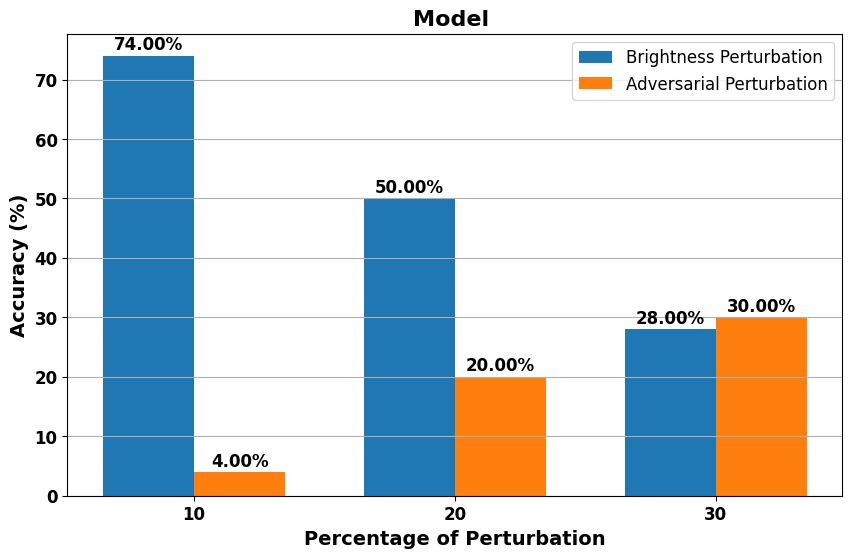

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

# Define the percentage changes for brightness perturbation and adversarial perturbation
percentage_changes = [10, 20, 30]

# Initialize lists to store accuracies for each type of perturbation
brightness_accuracies = []
adversarial_accuracies = []

# Calculate accuracies for brightness perturbation
for percentage in percentage_changes:
    perturbed_images = [adjust_brightness_random_pixels(image, percentage) for image in selected_correct_examples]
    accuracy = calculate_model_accuracy(classifier, np.array(perturbed_images), selected_labels)
    brightness_accuracies.append(accuracy)

# Calculate accuracies for adversarial perturbation
for percentage in percentage_changes:
    perturbed_adversarial = perturb_adversarial_with_original(x_adv_loaded, selected_correct_examples, percentage)
    predictions = classifier.predict(perturbed_adversarial, axis=1)
    correct_labels = selected_labels  # Ensure this matches the true labels accurately.
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(correct_labels, predicted_labels)
    adversarial_accuracies.append(accuracy)

# Create a bar plot
plt.figure(figsize=(10, 6))
width = 0.35
x = np.arange(len(percentage_changes))

# Bar plot for brightness perturbation
plt.bar(x - width/2, [accuracy * 100 for accuracy in brightness_accuracies], width, label='Brightness Perturbation')

# Bar plot for adversarial perturbation
plt.bar(x + width/2, [accuracy * 100 for accuracy in adversarial_accuracies], width, label='Adversarial Perturbation')

plt.title('Model ', fontsize=16, fontweight='bold')
plt.xlabel('Percentage of Perturbation', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.xticks(x, percentage_changes, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(axis='y')

# Add annotations to the bars
for i in range(len(percentage_changes)):
    plt.annotate(f'{brightness_accuracies[i] * 100:.2f}%', (x[i] - width/2, brightness_accuracies[i] * 100 + 1), ha='center', fontsize=12, fontweight='bold')
    plt.annotate(f'{adversarial_accuracies[i] * 100:.2f}%', (x[i] + width/2, adversarial_accuracies[i] * 100 + 1), ha='center', fontsize=12, fontweight='bold')
plt.savefig("modelrobustnessonrandompixels.png")
plt.show()


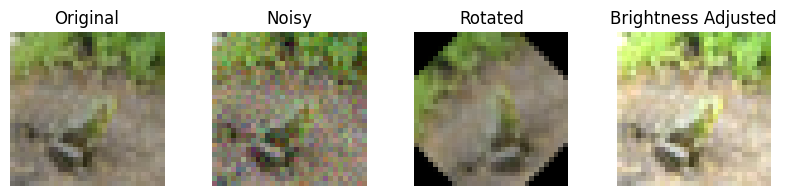

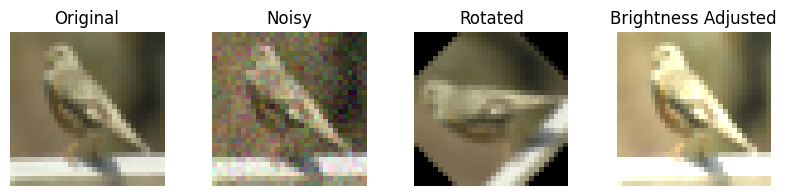

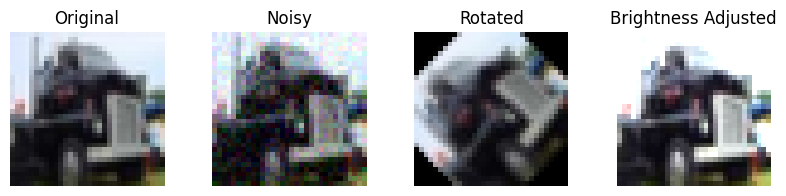

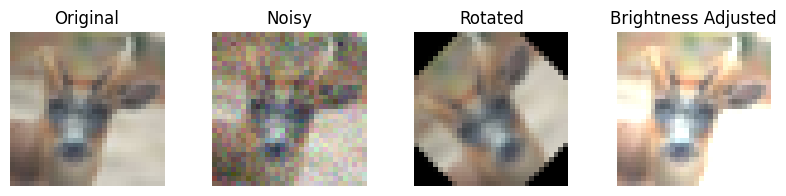

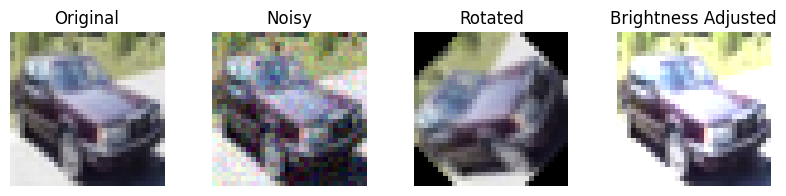

In [ ]:
import matplotlib.pyplot as plt

def visualize_images(image_list, title_list, figsize=(20, 10), num_examples=5):
    """
    Visualizes a limited number of images with corresponding titles.

    Parameters:
    - image_list: List of images to be displayed.
    - title_list: List of titles for each image.
    - figsize: Tuple indicating figure size.
    - num_examples: The number of examples to display (default is 5).
    """
    # Ensure we do not exceed the list size or the desired number of examples
    n = min(len(image_list), num_examples)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(image_list[i])
        plt.title(title_list[i])
        plt.axis('off')
    plt.show()

# Example usage with 5 examples
# Generate or select 5 specific examples and their titles
example_indices = [0, 1, 2, 3, 4]  # Just as an example, select the first 5 indices
selected_images = [selected_correct_examples[i] for i in example_indices]
noisy_images = [all_correct_noisy[i] for i in example_indices]
rotated_images = [all_correct_rotated[i] for i in example_indices]
brightness_adjusted_images = [all_correct_bright[i] for i in example_indices]

# Display each type of image modification in sequence for comparison
for i in range(len(example_indices)):
    visualize_images(
        [selected_images[i], noisy_images[i], rotated_images[i], brightness_adjusted_images[i]],
        ["Original", "Noisy", "Rotated", "Brightness Adjusted"],
        figsize=(10, 2)  # Adjust figure size as needed for visibility
    )


# **Global Probabilistic Guarantees**


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
# Define your data augmentation strategy
data_generator = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # apply shearing transformations
    zoom_range=0.2,  # randomly zoom image
    horizontal_flip=True,  # randomly flip images
    fill_mode='nearest'  # strategy used for filling in newly created pixels
)

augmented_images = []
augmented_labels = []

# Define how many augmented images you want per original image
augmentations_per_image = 5

for i in range(len(x_test)):

    # Generate 'augmentations_per_image' new images
    for _ in range(augmentations_per_image):
        iterator = data_generator.flow(selected_correct_examples, batch_size=1)
        augmented_image = next(iterator)[0].astype('float32')

        # Store the augmented image and its label
        augmented_images.append(augmented_image)
        augmented_labels.append(selected_labels)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

predictions = model.predict(augmented_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(augmented_labels, axis=1)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on augmented test set: {accuracy*100:.2f}%")


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Original data augmentation strategy
original_data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define a parameter grid for experimentation
param_grid = [
    {'rotation_range': 0, 'width_shift_range': 0.0, 'height_shift_range': 0.0, 'shear_range': 0.0, 'zoom_range': 0.0, 'horizontal_flip': False},
    {'rotation_range': 15, 'width_shift_range': 0.1, 'height_shift_range': 0.1, 'shear_range': 0.1, 'zoom_range': 0.1, 'horizontal_flip': True},
    {'rotation_range': 30, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'shear_range': 0.2, 'zoom_range': 0.2, 'horizontal_flip': True}
]

# Initialize lists to store results
results = []

# Iterate through parameter combinations
for params in param_grid:
    # Create a new data generator with the specified parameters
    data_generator = ImageDataGenerator(
        rotation_range=params['rotation_range'],
        width_shift_range=params['width_shift_range'],
        height_shift_range=params['height_shift_range'],
        shear_range=params['shear_range'],
        zoom_range=params['zoom_range'],
        horizontal_flip=params['horizontal_flip'],
        fill_mode='nearest'
    )

    # Generate augmented images
    augmented_images = []
    augmented_labels = []

    for i in range(len(x_test)):
        for _ in range(augmentations_per_image):
            iterator = data_generator.flow(selected_correct_examples, batch_size=1)
            augmented_image = next(iterator)[0].astype('float32')
            augmented_images.append(augmented_image)
            augmented_labels.append(selected_labels)

    # Convert lists to numpy arrays
    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    # Make predictions and calculate accuracy
    predictions = model.predict(augmented_images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(augmented_labels, axis=1)
    accuracy = accuracy_score(true_labels, predicted_labels)

    # Store the results
    results.append({
        'params': params,
        'accuracy': accuracy
    })

# Extract parameters and accuracies for plotting
param_names = [str(params) for params in param_grid]
accuracies = [result['accuracy'] * 100 for result in results]

# Create a bar plot with annotations
plt.figure(figsize=(12, 6))
plt.bar(param_names, accuracies)
plt.xlabel('Parameter Combinations', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.title('Accuracy for Different Augmentation Strategies', fontsize=16)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)

# Add annotations
for i, acc in enumerate(accuracies):
    plt.annotate(f'{acc:.2f}%', (i, acc), ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()
